In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.utils as nn_utils
import math
import scipy
from tqdm import tqdm
from tqdm import trange

device = torch.device("cuda" if torch.cuda.is_available() else "cpu" )
torch.autograd.set_detect_anomaly(True)
torch.manual_seed(128)

In [3]:
import torch.nn as nn
import os
torch.manual_seed(42)


class NeuralNet(nn.Module):

    def __init__(self,
                 input_dimension,
                 output_dimension,
                 n_hidden_layers,
                 neurons,
                 regularization_param,
                 regularization_exp,
                 retrain_seed,
                 L=1.0,
                 M=1):
        super(NeuralNet, self).__init__()
        # Number of input dimensions n
        self.input_dimension = input_dimension
        # Number of output dimensions m
        self.output_dimension = output_dimension
        # Number of neurons per layer
        self.neurons = neurons
        # Number of hidden layers
        self.n_hidden_layers = n_hidden_layers
        # Activation function
        self.activation = nn.Tanh()
        self.regularization_param = regularization_param
        # Regularization exponent
        self.regularization_exp = regularization_exp
        # Random seed for weight initialization

        self.input_layer = nn.Linear(self.input_dimension, self.neurons)
        self.hidden_layers = nn.ModuleList([
            nn.Linear(self.neurons, self.neurons)
            for _ in range(n_hidden_layers - 1)
        ])
        self.output_layer = nn.Linear(self.neurons, self.output_dimension)
        self.retrain_seed = retrain_seed
        # Random Seed for weight initialization
        self.init_xavier()
        self.L = L
        self.M = M

    def input_encoding(self, t, x):
        w = 2.0 * math.pi / self.L
        k = torch.arange(1, self.M + 1).to(device)
        out = torch.hstack([
            t.unsqueeze(1).to(device),
            torch.ones((t.shape[0],1)).to(device),
            torch.cos(w* torch.einsum('i,j->ji',k , x).to(device)),
            torch.sin(w* torch.einsum('i,j->ji',k , x).to(device))
        ])
        return out

    def forward(self, x):
        # The forward function performs the set of affine and non-linear
        # transformations defining the network (see equation above)
        x = x.to(device)
        x_encoded = self.input_encoding(x[:,0], x[:,1])
        x_encoded = self.activation(self.input_layer(x_encoded))
        for k, l in enumerate(self.hidden_layers):
            x_encoded = self.activation(l(x_encoded))
        return self.output_layer(x_encoded)

    def init_xavier(self):
        torch.manual_seed(self.retrain_seed)

        def init_weights(m):
            if type(
                    m
            ) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
                g = nn.init.calculate_gain('tanh')
                torch.nn.init.xavier_uniform_(m.weight, gain=g)
                # torch.nn.init.xavier_normal_(m.weight, gain=g)
                m.bias.data.fill_(0)

        self.apply(init_weights)

    def regularization(self):
        reg_loss = 0
        for name, param in self.named_parameters():
            if 'weight' in name:
                reg_loss = reg_loss + torch.norm(param, self.regularization_exp)
        return self.regularization_param * reg_loss

In [4]:
class Pinns_Kuramoto:
    def __init__(self, n_int_t_, n_int_x_, n_sb_, n_tb_, t_0_, t_1_, init_cond_, L=1.0, M=1):
        self.n_int_t = n_int_t_
        self.n_int_x = n_int_x_
        self.n_sb = n_sb_
        self.n_tb = n_tb_
        self.t0 = t_0_
        self.t1 = t_1_
        self.lambda_f = 50
        self.init_cond = init_cond_

        #Set constants
        self.alpha = 5
        self.beta = 0.5
        self.gamma = 0.005

        # Extrema of the solution domain 
        self.domain_extrema = torch.tensor([[self.t0,  self.t1],  [-1, 1]]) 

        # Number of space dimensions
        self.space_dimensions = 1


        # NN to Approximate Solution
        self.approximate_solution_flame = NeuralNet(input_dimension=2*M+2, output_dimension=1,
                                              n_hidden_layers=5,
                                              neurons=120,
                                              regularization_param=0.01,
                                              regularization_exp=2.,
                                              retrain_seed=42,L=2.0, M=1).to(device)
      # Generator of Sobol sequences
        self.soboleng = torch.quasirandom.SobolEngine(dimension=self.domain_extrema.shape[0], scramble = True)
        self.soboleng_int = torch.quasirandom.SobolEngine(dimension=1, scramble = True)

      # Training Sets S_tb, S_sb, S_int as Torch Dataloader
        self.training_set_tb, self.training_set_sb, self.training_set_int, = self.assemble_datasets()

    ################################################################################################

    def convert(self, tens):
        assert (tens.shape[1] == self.domain_extrema.shape[0])
        return tens * (self.domain_extrema[:, 1] - self.domain_extrema[:, 0]) + self.domain_extrema[:, 0]

    def convert_time(self, tens):
        #assert (tens.shape[1] == self.domain_extrema.shape[0])
        return tens * (self.domain_extrema[0, 1] - self.domain_extrema[0, 0]) + self.domain_extrema[0, 0]

    def convert_space(self, tens):
        #assert (tens.shape[] == self.domain_extrema.shape[0])
        return tens * (self.domain_extrema[1, 1] - self.domain_extrema[1, 0]) + self.domain_extrema[1, 0]

    def initial_conditions(self, x):
        if self.init_cond is None:
            return - torch.sin(math.pi * x)
        else:
            return self.init_cond.detach()

    def create_left_sb_mask(self, inp_sb):
        left_sb_mask = (inp_sb[:, 1] == -1)
        return left_sb_mask

    def create_right_sb_mask(self, inp_sb):
        right_sb_mask = (inp_sb[:, 1] == 1)
        return right_sb_mask

    ################################################################################################
    # Function returning the input-output tensor required to assemble the training set S_tb corresponding to the temporal boundary
    def add_temporal_boundary_points(self):
        t0 = self.domain_extrema[0, 0]
        x0 = self.domain_extrema[1, 0]
        xL = self.domain_extrema[1, 1]
        
        input_tb_x = torch.linspace(x0, xL, self.n_tb)
        input_tb_t = torch.full_like(input_tb_x, self.t0)
        input_tb = torch.cat((input_tb_t.unsqueeze(1),input_tb_x.unsqueeze(1)), dim=1)
        output_tb = self.initial_conditions(input_tb[:, 1]).reshape(-1, 1)
        
        return input_tb, output_tb

    # Function returning the input-output tensor required to assemble the training set S_sb corresponding to the spatial boundary
    def add_spatial_boundary_points(self):
        x0 = self.domain_extrema[1, 0]
        xL = self.domain_extrema[1, 1]

        input_sb = self.convert(self.soboleng.draw(self.n_sb))

        input_sb_0 = torch.clone(input_sb)
        input_sb_0[:, 1] = torch.full(input_sb_0[:, 1].shape, x0)

        input_sb_L = torch.clone(input_sb)
        input_sb_L[:, 1] = torch.full(input_sb_L[:, 1].shape, xL)

        output_sb_0 = torch.zeros((input_sb.shape[0], 1))
        output_sb_L = torch.zeros((input_sb.shape[0], 1))

        return torch.cat([input_sb_0, input_sb_L], 0), torch.cat([output_sb_0, output_sb_L], 0)

    #  Function returning the input-output tensor required to assemble the training set S_int corresponding to the interior domain where the PDE is enforced
    def add_interior_points(self):
        """
        t0 = self.domain_extrema[0, 0]
        t1 = self.domain_extrema[0, 1]
        x0 = self.domain_extrema[1, 0]
        xL = self.domain_extrema[1, 1]
        
        inpt = torch.linspace(t0 + self.epsilon, t1 - self.epsilon, self.n_int_t)
        inpx = torch.linspace(x0 + self.epsilon, xL - self.epsilon, self.n_int_x)
        tt, xx = torch.meshgrid(inpt, inpx)

        input_int = torch.cat((tt.flatten().unsqueeze(1), xx.flatten().unsqueeze(1)), dim=1)
        output_int = torch.zeros((input_int.shape[0], 1))
        """
        
        input_time = self.convert(self.soboleng.draw(self.n_int_t))
        inpt = input_time[:, 0].unique()
        inpx = self.convert_space(self.soboleng_int.draw(self.n_int_x)).squeeze(1)
        tt, xx = torch.meshgrid(inpt, inpx)

        input_int = torch.cat((tt.flatten().unsqueeze(1), xx.flatten().unsqueeze(1)), dim=1)
        output_int = torch.zeros((input_int.shape[0], 1))
        
        return input_int, output_int


    # Function returning the training sets S_sb, S_tb, S_int as dataloader
    def assemble_datasets(self):
        input_tb, output_tb = self.add_temporal_boundary_points()  # S_tb
        input_sb, output_sb = self.add_spatial_boundary_points()  # S_sb
        input_int, output_int = self.add_interior_points()  # S_int

        input_tb, output_tb = input_tb.to(device), output_tb.to(device)
        input_sb, output_sb = input_sb.to(device), output_sb.to(device)
        input_int, output_int = input_int.to(device), output_int.to(device)

        training_set_tb = DataLoader(torch.utils.data.TensorDataset(input_tb, output_tb), batch_size=self.n_tb, shuffle=False)
        training_set_sb = DataLoader(torch.utils.data.TensorDataset(input_sb, output_sb), batch_size=2 * self.space_dimensions * self.n_sb, shuffle=False) #2 * self.space_dimensions * self.n_sb
        training_set_int = DataLoader(torch.utils.data.TensorDataset(input_int, output_int), batch_size=self.n_int_t * self.n_int_x, shuffle=False)

        return training_set_tb, training_set_sb, training_set_int


################################################################################################

    #   Compute Temporal Boundary Residuals
    def compute_temporal_boundary_residual(self, input_tb, output_tb):
        assert(torch.all(input_tb[:,0] == self.t0))
        u = self.approximate_solution_flame(input_tb).reshape(-1,)
        temp_tb_train = output_tb.reshape(-1,)

        assert(u.shape == temp_tb_train.shape)
        residual_tb = temp_tb_train - u

        return residual_tb.reshape(-1,)
    """
    #   Compute Spatial Boundary Residuals
    def compute_spatial_boundary_residual(self, input_sb, output_sb):
        u = self.approximate_solution_flame(input_sb).reshape(-1,)

        mask_L = self.create_left_sb_mask(input_sb)
        mask_R = self.create_right_sb_mask(input_sb)
        assert(u[mask_L].shape == u[mask_R].shape)

        residual_sb = u[mask_L] - u[mask_R]

        return residual_sb.reshape(-1,)
    """
    #   Compute Interior Residuals
    def compute_interior_residual(self, input_int):
        input_int.requires_grad = True
        u = self.approximate_solution_flame(input_int).reshape(-1,)

        grad_u = torch.autograd.grad(u.sum(), input_int, create_graph=True)[0]
        grad_u_t = grad_u[:, 0]
        grad_u_x = grad_u[:, 1]
        grad_u_xx = torch.autograd.grad(grad_u_x.sum(), input_int, create_graph=True)[0][:, 1]
        grad_u_xxx = torch.autograd.grad(grad_u_xx.sum(), input_int, create_graph=True)[0][:, 1]
        grad_u_xxxx = torch.autograd.grad(grad_u_xxx.sum(), input_int, create_graph=True)[0][:, 1]

        assert(u.shape == grad_u_t.shape and u.shape == grad_u_x.shape and u.shape == grad_u_xx.shape )

        residual_int = grad_u_t + self.alpha*u*grad_u_x + self.beta*grad_u_xx + self.gamma*grad_u_xxxx
        
        return residual_int.reshape(-1,)
        #return residual_int.reshape(self.n_int_x,self.n_int_t)


    #   Function to compute the total loss (weighted sum of spatial boundary loss, temporal boundary loss and interior loss)
    def compute_loss(self, inp_train_tb, T_train_tb, inp_train_sb, T_train_sb, inp_train_int, T_train_int, verbose=True):
        
        # Temporal Boundary Residuals
        r_tb = self.compute_temporal_boundary_residual(inp_train_tb, T_train_tb)

        # Interior Residuals
        r_int = self.compute_interior_residual(inp_train_int)

        loss_tb = torch.mean(abs(r_tb) ** 2)
        loss_int = torch.mean(abs(r_int) ** 2)

        loss = torch.log10(self.lambda_f * loss_tb  + loss_int)
        if verbose: print("Total loss: ", round(loss.item(), 4), "| PDE Loss: ", round(torch.log10(loss_int).item(), 4), "| Temporal Loss: ", round(torch.log10(loss_tb).item(), 4))

        return loss
    
    ################################################################################################
    
    
    def fit(self, num_epochs, optimizer, verbose=True):
        history = list()
        
        # Loop over epochs
        for epoch in range(num_epochs):
            if verbose: print("################################ ", epoch, " ################################")

            for j, ((inp_train_tb, u_train_tb), (inp_train_sb, u_train_sb), (inp_train_int, u_train_int)) in enumerate(zip(self.training_set_tb, self.training_set_sb, self.training_set_int)):
                def closure():
                    optimizer.zero_grad()
                    loss = self.compute_loss(inp_train_tb, u_train_tb, inp_train_sb, u_train_sb, inp_train_int, u_train_int, verbose=True)
                    loss.backward()
                    #nn_utils.clip_grad_norm_(self.approximate_solution_flame.parameters(), max_norm=1.0)

                    history.append(loss.item())
                    return loss

                optimizer.step(closure=closure)

        print('Final Loss: ', history[-1])

        return history


In [5]:
n_int_t = 64
n_int_x = 128
n_sb = 512
n_tb = 1024

In [6]:
n_epochs = 1
max_eval = 50000

# Marching Steps
N = 10
init_cond = None

# Create Array to Store Plots
final_image = torch.tensor([]).to(device)
final_inputs = torch.tensor([]).to(device)


for i in range(N):
    
    # Initialise Model for New Time Interval
    t_0, t_1 = (1/N) * i, (1/N) * (i+1)    
    model = Pinns_Kuramoto(n_int_t, n_int_x, n_sb, n_tb, t_0, t_1, init_cond)
    
    # Create New Optimizer
    optimizer_LBFGS = optim.LBFGS(list(model.approximate_solution_flame.parameters()),
                              lr=float(0.5),
                              max_iter=1000,
                              max_eval=max_eval,
                              history_size=150,
                              line_search_fn="strong_wolfe",
                              tolerance_change=1.0 * np.finfo(float).eps)
    
    # Inputs for Plots
    inputs = model.soboleng.draw(50000)
    inputs = model.convert(inputs).to(device)
    
    # Train Time Interval
    hist = model.fit(num_epochs=n_epochs,
                    optimizer=optimizer_LBFGS,
                    verbose=True)
    """
    plt.figure(dpi=150)
    plt.grid(True, which="both", ls=":")
    plt.plot(np.arange(1, len(hist) + 1), hist, label="Train Loss")
    plt.xscale("log")
    plt.legend()
    """
    
    x_init = torch.linspace(-1, 1, n_tb)
    t_init = torch.full_like(x_init, t_1)
    inp_init = torch.cat((t_init.unsqueeze(1),x_init.unsqueeze(1)), dim=1).to(device)
    init_cond = model.approximate_solution_flame(inp_init)

    output_fluid = model.approximate_solution_flame(inputs.to(device))
    final_inputs = torch.cat((final_inputs, inputs), dim = 0).to(device)
    final_image = torch.cat((final_image, output_fluid), dim = 0).to(device)

C:\Users\matth\AppData\Roaming\Python\Python310\site-packages\torch\functional.py:505: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3491.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


################################  0  ################################
Total loss:  2.6358 | PDE Loss:  2.5245 | Temporal Loss:  0.291
Total loss:  2.6031 | PDE Loss:  2.4867 | Temporal Loss:  0.2757
Total loss:  2.3097 | PDE Loss:  2.136 | Temporal Loss:  0.1287
Total loss:  2.0281 | PDE Loss:  1.8511 | Temporal Loss:  -0.1462
Total loss:  1.7671 | PDE Loss:  1.6416 | Temporal Loss:  -0.5322
Total loss:  1.5674 | PDE Loss:  1.5057 | Temporal Loss:  -1.0095
Total loss:  1.3396 | PDE Loss:  1.237 | Temporal Loss:  -1.0364
Total loss:  1.2465 | PDE Loss:  0.9593 | Temporal Loss:  -0.7677
Total loss:  1.2025 | PDE Loss:  0.9186 | Temporal Loss:  -0.8153
Total loss:  1.1372 | PDE Loss:  0.8887 | Temporal Loss:  -0.9225
Total loss:  1.1065 | PDE Loss:  0.8475 | Temporal Loss:  -0.9401
Total loss:  1.0801 | PDE Loss:  0.8322 | Temporal Loss:  -0.9805
Total loss:  1.0613 | PDE Loss:  0.7621 | Temporal Loss:  -0.9405
Total loss:  1.0524 | PDE Loss:  0.7472 | Temporal Loss:  -0.9434
Total loss: 

Total loss:  0.5883 | PDE Loss:  0.1582 | Temporal Loss:  -1.3124
Total loss:  0.5862 | PDE Loss:  0.1521 | Temporal Loss:  -1.3121
Total loss:  0.584 | PDE Loss:  0.1435 | Temporal Loss:  -1.3107
Total loss:  0.5816 | PDE Loss:  0.1367 | Temporal Loss:  -1.3105
Total loss:  0.5795 | PDE Loss:  0.134 | Temporal Loss:  -1.3123
Total loss:  0.5767 | PDE Loss:  0.1232 | Temporal Loss:  -1.3106
Total loss:  0.5752 | PDE Loss:  0.121 | Temporal Loss:  -1.3117
Total loss:  0.5732 | PDE Loss:  0.1193 | Temporal Loss:  -1.314
Total loss:  0.5702 | PDE Loss:  0.1156 | Temporal Loss:  -1.3166
Total loss:  0.5684 | PDE Loss:  0.1174 | Temporal Loss:  -1.3203
Total loss:  0.5675 | PDE Loss:  0.1173 | Temporal Loss:  -1.3217
Total loss:  0.5669 | PDE Loss:  0.1187 | Temporal Loss:  -1.3234
Total loss:  0.566 | PDE Loss:  0.1192 | Temporal Loss:  -1.325
Total loss:  0.5646 | PDE Loss:  0.1212 | Temporal Loss:  -1.3284
Total loss:  0.5624 | PDE Loss:  0.1212 | Temporal Loss:  -1.3317
Total loss:  0.5

Total loss:  0.4218 | PDE Loss:  0.1656 | Temporal Loss:  -1.6283
Total loss:  0.4212 | PDE Loss:  0.1636 | Temporal Loss:  -1.6271
Total loss:  0.4207 | PDE Loss:  0.162 | Temporal Loss:  -1.6262
Total loss:  0.4201 | PDE Loss:  0.1618 | Temporal Loss:  -1.6273
Total loss:  0.4195 | PDE Loss:  0.1617 | Temporal Loss:  -1.6285
Total loss:  0.4186 | PDE Loss:  0.1619 | Temporal Loss:  -1.6307
Total loss:  0.4174 | PDE Loss:  0.1655 | Temporal Loss:  -1.638
Total loss:  0.4159 | PDE Loss:  0.1668 | Temporal Loss:  -1.6432
Total loss:  0.4136 | PDE Loss:  0.1687 | Temporal Loss:  -1.6508
Total loss:  0.4096 | PDE Loss:  0.1732 | Temporal Loss:  -1.6663
Total loss:  0.4067 | PDE Loss:  0.1763 | Temporal Loss:  -1.6778
Total loss:  0.4045 | PDE Loss:  0.1752 | Temporal Loss:  -1.6815
Total loss:  0.403 | PDE Loss:  0.1793 | Temporal Loss:  -1.6912
Total loss:  0.4021 | PDE Loss:  0.1766 | Temporal Loss:  -1.6893
Total loss:  0.4013 | PDE Loss:  0.1713 | Temporal Loss:  -1.6836
Total loss:  

Total loss:  0.2401 | PDE Loss:  0.0789 | Temporal Loss:  -1.9675
Total loss:  0.2381 | PDE Loss:  0.0801 | Temporal Loss:  -1.9765
Total loss:  0.2364 | PDE Loss:  0.0824 | Temporal Loss:  -1.9874
Total loss:  0.2352 | PDE Loss:  0.0823 | Temporal Loss:  -1.9913
Total loss:  0.2339 | PDE Loss:  0.0831 | Temporal Loss:  -1.9977
Total loss:  0.2326 | PDE Loss:  0.0825 | Temporal Loss:  -2.0005
Total loss:  0.2315 | PDE Loss:  0.0814 | Temporal Loss:  -2.0018
Total loss:  0.2299 | PDE Loss:  0.0801 | Temporal Loss:  -2.004
Total loss:  0.2281 | PDE Loss:  0.0759 | Temporal Loss:  -2.0002
Total loss:  0.2259 | PDE Loss:  0.0713 | Temporal Loss:  -1.9966
Total loss:  0.2241 | PDE Loss:  0.0671 | Temporal Loss:  -1.9927
Total loss:  0.2222 | PDE Loss:  0.0626 | Temporal Loss:  -1.9889
Total loss:  0.2201 | PDE Loss:  0.0562 | Temporal Loss:  -1.9813
Total loss:  0.2189 | PDE Loss:  0.054 | Temporal Loss:  -1.9804
Total loss:  0.2177 | PDE Loss:  0.0512 | Temporal Loss:  -1.9781
Total loss: 

Total loss:  0.0136 | PDE Loss:  -0.1276 | Temporal Loss:  -2.2421
Total loss:  0.0104 | PDE Loss:  -0.127 | Temporal Loss:  -2.2553
Total loss:  0.0072 | PDE Loss:  -0.1272 | Temporal Loss:  -2.2666
Total loss:  0.0038 | PDE Loss:  -0.1299 | Temporal Loss:  -2.2721
Total loss:  0.0007 | PDE Loss:  -0.1295 | Temporal Loss:  -2.285
Total loss:  -0.0024 | PDE Loss:  -0.1321 | Temporal Loss:  -2.2896
Total loss:  -0.0054 | PDE Loss:  -0.1346 | Temporal Loss:  -2.2939
Total loss:  -0.0097 | PDE Loss:  -0.1401 | Temporal Loss:  -2.2947
Total loss:  -0.0134 | PDE Loss:  -0.1412 | Temporal Loss:  -2.3059
Total loss:  -0.0164 | PDE Loss:  -0.1435 | Temporal Loss:  -2.3112
Total loss:  -0.0193 | PDE Loss:  -0.1442 | Temporal Loss:  -2.3204
Total loss:  -0.022 | PDE Loss:  -0.1456 | Temporal Loss:  -2.3271
Total loss:  -0.0238 | PDE Loss:  -0.1454 | Temporal Loss:  -2.335
Total loss:  -0.0267 | PDE Loss:  -0.1466 | Temporal Loss:  -2.3431
Total loss:  -0.0302 | PDE Loss:  -0.1496 | Temporal Loss

Total loss:  -0.5062 | PDE Loss:  -0.6267 | Temporal Loss:  -2.8207
Total loss:  -0.5099 | PDE Loss:  -0.6329 | Temporal Loss:  -2.8167
Total loss:  -0.5155 | PDE Loss:  -0.6399 | Temporal Loss:  -2.8181
Total loss:  -0.5219 | PDE Loss:  -0.6489 | Temporal Loss:  -2.8167
Total loss:  -0.5277 | PDE Loss:  -0.656 | Temporal Loss:  -2.8188
Total loss:  -0.5329 | PDE Loss:  -0.6586 | Temporal Loss:  -2.8316
Total loss:  -0.5364 | PDE Loss:  -0.6622 | Temporal Loss:  -2.8347
Total loss:  -0.5391 | PDE Loss:  -0.6648 | Temporal Loss:  -2.8377
Total loss:  -0.5411 | PDE Loss:  -0.6638 | Temporal Loss:  -2.8489
Total loss:  -0.5431 | PDE Loss:  -0.6644 | Temporal Loss:  -2.8553
Total loss:  -0.5449 | PDE Loss:  -0.6679 | Temporal Loss:  -2.8518
Total loss:  -0.5468 | PDE Loss:  -0.6701 | Temporal Loss:  -2.8529
Total loss:  -0.549 | PDE Loss:  -0.6734 | Temporal Loss:  -2.8516
Total loss:  -0.5512 | PDE Loss:  -0.6785 | Temporal Loss:  -2.8453
Total loss:  -0.5548 | PDE Loss:  -0.6854 | Tempor

Total loss:  -0.952 | PDE Loss:  -1.0395 | Temporal Loss:  -3.3895
Total loss:  -0.9557 | PDE Loss:  -1.0436 | Temporal Loss:  -3.3919
Total loss:  -0.9598 | PDE Loss:  -1.0485 | Temporal Loss:  -3.3922
Total loss:  -0.9633 | PDE Loss:  -1.052 | Temporal Loss:  -3.396
Total loss:  -0.9658 | PDE Loss:  -1.0552 | Temporal Loss:  -3.3952
Total loss:  -0.9682 | PDE Loss:  -1.059 | Temporal Loss:  -3.3914
Total loss:  -0.9707 | PDE Loss:  -1.0628 | Temporal Loss:  -3.3885
Total loss:  -0.9733 | PDE Loss:  -1.0663 | Temporal Loss:  -3.3871
Total loss:  -0.9764 | PDE Loss:  -1.0705 | Temporal Loss:  -3.3855
Total loss:  -0.9804 | PDE Loss:  -1.0771 | Temporal Loss:  -3.3794
Total loss:  -0.9853 | PDE Loss:  -1.0815 | Temporal Loss:  -3.3859
Total loss:  -0.991 | PDE Loss:  -1.088 | Temporal Loss:  -3.3886
Total loss:  -0.9977 | PDE Loss:  -1.0956 | Temporal Loss:  -3.3921
Total loss:  -1.0052 | PDE Loss:  -1.1026 | Temporal Loss:  -3.4012
Total loss:  -1.0112 | PDE Loss:  -1.1082 | Temporal L

Total loss:  -1.4236 | PDE Loss:  -1.4705 | Temporal Loss:  -4.1123
Total loss:  -1.4265 | PDE Loss:  -1.4726 | Temporal Loss:  -4.1229
Total loss:  -1.4297 | PDE Loss:  -1.4748 | Temporal Loss:  -4.1345
Total loss:  -1.4326 | PDE Loss:  -1.4762 | Temporal Loss:  -4.151
Total loss:  -1.4346 | PDE Loss:  -1.4769 | Temporal Loss:  -4.1663
Total loss:  -1.4361 | PDE Loss:  -1.4776 | Temporal Loss:  -4.1753
Total loss:  -1.4375 | PDE Loss:  -1.4781 | Temporal Loss:  -4.1856
Total loss:  -1.439 | PDE Loss:  -1.4791 | Temporal Loss:  -4.1932
Total loss:  -1.4405 | PDE Loss:  -1.4803 | Temporal Loss:  -4.1973
Total loss:  -1.4424 | PDE Loss:  -1.4822 | Temporal Loss:  -4.1998
Total loss:  -1.4455 | PDE Loss:  -1.4851 | Temporal Loss:  -4.2042
Total loss:  -1.4492 | PDE Loss:  -1.4912 | Temporal Loss:  -4.184
Total loss:  -1.4527 | PDE Loss:  -1.4931 | Temporal Loss:  -4.203
Total loss:  -1.456 | PDE Loss:  -1.4979 | Temporal Loss:  -4.192
Total loss:  -1.4605 | PDE Loss:  -1.505 | Temporal Lo

Total loss:  -1.789 | PDE Loss:  -1.8392 | Temporal Loss:  -4.4495
Total loss:  -1.7917 | PDE Loss:  -1.8413 | Temporal Loss:  -4.4578
Total loss:  -1.7936 | PDE Loss:  -1.8426 | Temporal Loss:  -4.4644
Total loss:  -1.7952 | PDE Loss:  -1.8432 | Temporal Loss:  -4.4746
Total loss:  -1.7966 | PDE Loss:  -1.844 | Temporal Loss:  -4.481
Total loss:  -1.7978 | PDE Loss:  -1.8447 | Temporal Loss:  -4.4871
Total loss:  -1.799 | PDE Loss:  -1.8456 | Temporal Loss:  -4.4905
Total loss:  -1.8003 | PDE Loss:  -1.8464 | Temporal Loss:  -4.4962
Total loss:  -1.802 | PDE Loss:  -1.848 | Temporal Loss:  -4.4991
Total loss:  -1.8044 | PDE Loss:  -1.8502 | Temporal Loss:  -4.5021
Total loss:  -1.8074 | PDE Loss:  -1.8526 | Temporal Loss:  -4.5108
Total loss:  -1.8104 | PDE Loss:  -1.8561 | Temporal Loss:  -4.5096
Total loss:  -1.8134 | PDE Loss:  -1.8584 | Temporal Loss:  -4.5195
Total loss:  -1.8161 | PDE Loss:  -1.8609 | Temporal Loss:  -4.5237
Total loss:  -1.8199 | PDE Loss:  -1.8649 | Temporal L

Total loss:  0.604 | PDE Loss:  -0.0686 | Temporal Loss:  -1.1987
Total loss:  0.601 | PDE Loss:  -0.071 | Temporal Loss:  -1.2019
Total loss:  0.5983 | PDE Loss:  -0.0717 | Temporal Loss:  -1.2051
Total loss:  0.5965 | PDE Loss:  -0.0665 | Temporal Loss:  -1.2089
Total loss:  0.5955 | PDE Loss:  -0.0643 | Temporal Loss:  -1.2108
Total loss:  0.5945 | PDE Loss:  -0.0633 | Temporal Loss:  -1.2124
Total loss:  0.5933 | PDE Loss:  -0.0611 | Temporal Loss:  -1.2145
Total loss:  0.5921 | PDE Loss:  -0.0618 | Temporal Loss:  -1.2159
Total loss:  0.5901 | PDE Loss:  -0.0634 | Temporal Loss:  -1.218
Total loss:  0.5873 | PDE Loss:  -0.0635 | Temporal Loss:  -1.2215
Total loss:  0.5843 | PDE Loss:  -0.0655 | Temporal Loss:  -1.2247
Total loss:  0.5816 | PDE Loss:  -0.0605 | Temporal Loss:  -1.2298
Total loss:  0.5789 | PDE Loss:  -0.0571 | Temporal Loss:  -1.2343
Total loss:  0.5755 | PDE Loss:  -0.056 | Temporal Loss:  -1.2391
Total loss:  0.5708 | PDE Loss:  -0.0511 | Temporal Loss:  -1.2467


Total loss:  0.3655 | PDE Loss:  0.0217 | Temporal Loss:  -1.5956
Total loss:  0.3633 | PDE Loss:  0.0251 | Temporal Loss:  -1.6025
Total loss:  0.3618 | PDE Loss:  0.0289 | Temporal Loss:  -1.6085
Total loss:  0.361 | PDE Loss:  0.0293 | Temporal Loss:  -1.6103
Total loss:  0.3603 | PDE Loss:  0.0298 | Temporal Loss:  -1.6122
Total loss:  0.3598 | PDE Loss:  0.0299 | Temporal Loss:  -1.6132
Total loss:  0.3592 | PDE Loss:  0.0307 | Temporal Loss:  -1.6149
Total loss:  0.3586 | PDE Loss:  0.0315 | Temporal Loss:  -1.6168
Total loss:  0.3579 | PDE Loss:  0.0326 | Temporal Loss:  -1.6191
Total loss:  0.3564 | PDE Loss:  0.0349 | Temporal Loss:  -1.624
Total loss:  0.3548 | PDE Loss:  0.0383 | Temporal Loss:  -1.6302
Total loss:  0.3535 | PDE Loss:  0.0403 | Temporal Loss:  -1.6347
Total loss:  0.3522 | PDE Loss:  0.0428 | Temporal Loss:  -1.6396
Total loss:  0.3506 | PDE Loss:  0.0442 | Temporal Loss:  -1.6442
Total loss:  0.3489 | PDE Loss:  0.0468 | Temporal Loss:  -1.65
Total loss:  0

Total loss:  0.0502 | PDE Loss:  -0.04 | Temporal Loss:  -2.3754
Total loss:  0.0453 | PDE Loss:  -0.0396 | Temporal Loss:  -2.4041
Total loss:  0.0395 | PDE Loss:  -0.0404 | Temporal Loss:  -2.4338
Total loss:  0.0344 | PDE Loss:  -0.0417 | Temporal Loss:  -2.4588
Total loss:  0.0295 | PDE Loss:  -0.0432 | Temporal Loss:  -2.4811
Total loss:  0.0253 | PDE Loss:  -0.0452 | Temporal Loss:  -2.4982
Total loss:  0.0215 | PDE Loss:  -0.051 | Temporal Loss:  -2.4905
Total loss:  0.0176 | PDE Loss:  -0.0574 | Temporal Loss:  -2.4808
Total loss:  0.0118 | PDE Loss:  -0.067 | Temporal Loss:  -2.4676
Total loss:  0.0047 | PDE Loss:  -0.0766 | Temporal Loss:  -2.4621
Total loss:  -0.0033 | PDE Loss:  -0.0873 | Temporal Loss:  -2.4573
Total loss:  -0.0092 | PDE Loss:  -0.0933 | Temporal Loss:  -2.4626
Total loss:  -0.0134 | PDE Loss:  -0.0966 | Temporal Loss:  -2.471
Total loss:  -0.0168 | PDE Loss:  -0.0982 | Temporal Loss:  -2.4827
Total loss:  -0.0219 | PDE Loss:  -0.102 | Temporal Loss:  -2.4

Total loss:  -0.3682 | PDE Loss:  -0.524 | Temporal Loss:  -2.5879
Total loss:  -0.3708 | PDE Loss:  -0.5285 | Temporal Loss:  -2.5863
Total loss:  -0.3733 | PDE Loss:  -0.5324 | Temporal Loss:  -2.5856
Total loss:  -0.3765 | PDE Loss:  -0.534 | Temporal Loss:  -2.5922
Total loss:  -0.3772 | PDE Loss:  -0.5322 | Temporal Loss:  -2.5989
Total loss:  -0.3802 | PDE Loss:  -0.5353 | Temporal Loss:  -2.6018
Total loss:  -0.3817 | PDE Loss:  -0.5375 | Temporal Loss:  -2.6015
Total loss:  -0.3826 | PDE Loss:  -0.5377 | Temporal Loss:  -2.6039
Total loss:  -0.3837 | PDE Loss:  -0.5381 | Temporal Loss:  -2.6068
Total loss:  -0.3849 | PDE Loss:  -0.5386 | Temporal Loss:  -2.6094
Total loss:  -0.3862 | PDE Loss:  -0.5393 | Temporal Loss:  -2.6124
Total loss:  -0.3879 | PDE Loss:  -0.5404 | Temporal Loss:  -2.6154
Total loss:  -0.39 | PDE Loss:  -0.5426 | Temporal Loss:  -2.6172
Total loss:  -0.3924 | PDE Loss:  -0.5451 | Temporal Loss:  -2.6193
Total loss:  -0.3946 | PDE Loss:  -0.548 | Temporal 

Total loss:  -0.7079 | PDE Loss:  -0.8975 | Temporal Loss:  -2.858
Total loss:  -0.7111 | PDE Loss:  -0.9001 | Temporal Loss:  -2.8624
Total loss:  -0.7139 | PDE Loss:  -0.903 | Temporal Loss:  -2.8651
Total loss:  -0.7169 | PDE Loss:  -0.9061 | Temporal Loss:  -2.8678
Total loss:  -0.7203 | PDE Loss:  -0.9116 | Temporal Loss:  -2.8674
Total loss:  -0.7231 | PDE Loss:  -0.917 | Temporal Loss:  -2.8656
Total loss:  -0.7251 | PDE Loss:  -0.9202 | Temporal Loss:  -2.8654
Total loss:  -0.7268 | PDE Loss:  -0.9258 | Temporal Loss:  -2.8604
Total loss:  -0.7285 | PDE Loss:  -0.929 | Temporal Loss:  -2.8594
Total loss:  -0.7302 | PDE Loss:  -0.9329 | Temporal Loss:  -2.8573
Total loss:  -0.7322 | PDE Loss:  -0.9369 | Temporal Loss:  -2.8562
Total loss:  -0.7349 | PDE Loss:  -0.9411 | Temporal Loss:  -2.8565
Total loss:  -0.7376 | PDE Loss:  -0.9433 | Temporal Loss:  -2.86
Total loss:  -0.74 | PDE Loss:  -0.9467 | Temporal Loss:  -2.8608
Total loss:  -0.7418 | PDE Loss:  -0.9462 | Temporal Los

Total loss:  -0.8616 | PDE Loss:  -1.1534 | Temporal Loss:  -2.871
Total loss:  -0.8622 | PDE Loss:  -1.1537 | Temporal Loss:  -2.8719
Total loss:  -0.8627 | PDE Loss:  -1.1544 | Temporal Loss:  -2.8722
Total loss:  -0.8631 | PDE Loss:  -1.1544 | Temporal Loss:  -2.873
Total loss:  -0.8634 | PDE Loss:  -1.155 | Temporal Loss:  -2.8731
Total loss:  -0.8636 | PDE Loss:  -1.1552 | Temporal Loss:  -2.8733
Total loss:  -0.8639 | PDE Loss:  -1.1555 | Temporal Loss:  -2.8735
Total loss:  -0.8642 | PDE Loss:  -1.1564 | Temporal Loss:  -2.8732
Total loss:  -0.8646 | PDE Loss:  -1.157 | Temporal Loss:  -2.8733
Total loss:  -0.865 | PDE Loss:  -1.1582 | Temporal Loss:  -2.873
Total loss:  -0.8656 | PDE Loss:  -1.1593 | Temporal Loss:  -2.873
Total loss:  -0.8662 | PDE Loss:  -1.1606 | Temporal Loss:  -2.8729
Total loss:  -0.8668 | PDE Loss:  -1.162 | Temporal Loss:  -2.8728
Total loss:  -0.8674 | PDE Loss:  -1.1626 | Temporal Loss:  -2.8734
Total loss:  -0.8679 | PDE Loss:  -1.1633 | Temporal Los

Total loss:  -0.898 | PDE Loss:  -1.2337 | Temporal Loss:  -2.8658
Total loss:  -0.8981 | PDE Loss:  -1.2337 | Temporal Loss:  -2.8661
Total loss:  -0.8982 | PDE Loss:  -1.2335 | Temporal Loss:  -2.8665
Total loss:  -0.8984 | PDE Loss:  -1.2337 | Temporal Loss:  -2.8666
Total loss:  -0.8985 | PDE Loss:  -1.2336 | Temporal Loss:  -2.867
Total loss:  -0.8987 | PDE Loss:  -1.2342 | Temporal Loss:  -2.8668
Total loss:  -0.8989 | PDE Loss:  -1.2347 | Temporal Loss:  -2.8668
Total loss:  -0.8992 | PDE Loss:  -1.2354 | Temporal Loss:  -2.8667
Total loss:  -0.8996 | PDE Loss:  -1.2367 | Temporal Loss:  -2.8662
Total loss:  -0.8999 | PDE Loss:  -1.2379 | Temporal Loss:  -2.8658
Total loss:  -0.9001 | PDE Loss:  -1.2388 | Temporal Loss:  -2.8655
Total loss:  -0.9003 | PDE Loss:  -1.2399 | Temporal Loss:  -2.8649
Total loss:  -0.9005 | PDE Loss:  -1.2403 | Temporal Loss:  -2.8649
Total loss:  -0.9006 | PDE Loss:  -1.2409 | Temporal Loss:  -2.8647
Total loss:  -0.9008 | PDE Loss:  -1.2412 | Tempor

Total loss:  -0.9146 | PDE Loss:  -1.3017 | Temporal Loss:  -2.8428
Total loss:  -0.9146 | PDE Loss:  -1.3024 | Temporal Loss:  -2.8424
Total loss:  -0.9147 | PDE Loss:  -1.3035 | Temporal Loss:  -2.8417
Total loss:  -0.9148 | PDE Loss:  -1.304 | Temporal Loss:  -2.8415
Total loss:  -0.9148 | PDE Loss:  -1.3044 | Temporal Loss:  -2.8413
Total loss:  -0.9149 | PDE Loss:  -1.3046 | Temporal Loss:  -2.8413
Total loss:  -0.9149 | PDE Loss:  -1.3047 | Temporal Loss:  -2.8413
Total loss:  -0.915 | PDE Loss:  -1.3046 | Temporal Loss:  -2.8415
Total loss:  -0.915 | PDE Loss:  -1.3046 | Temporal Loss:  -2.8416
Total loss:  -0.9151 | PDE Loss:  -1.3045 | Temporal Loss:  -2.8417
Total loss:  -0.9151 | PDE Loss:  -1.3043 | Temporal Loss:  -2.8419
Total loss:  -0.9152 | PDE Loss:  -1.3042 | Temporal Loss:  -2.8421
Total loss:  -0.9153 | PDE Loss:  -1.3043 | Temporal Loss:  -2.8421
Total loss:  -0.9153 | PDE Loss:  -1.3044 | Temporal Loss:  -2.8422
Total loss:  -0.9155 | PDE Loss:  -1.3051 | Tempora

Total loss:  0.7142 | PDE Loss:  0.4438 | Temporal Loss:  -1.3186
Total loss:  0.7091 | PDE Loss:  0.4447 | Temporal Loss:  -1.3309
Total loss:  0.7045 | PDE Loss:  0.4546 | Temporal Loss:  -1.3534
Total loss:  0.7012 | PDE Loss:  0.4658 | Temporal Loss:  -1.3761
Total loss:  0.6967 | PDE Loss:  0.4786 | Temporal Loss:  -1.4059
Total loss:  0.6935 | PDE Loss:  0.4834 | Temporal Loss:  -1.4217
Total loss:  0.6868 | PDE Loss:  0.4892 | Temporal Loss:  -1.4491
Total loss:  0.6825 | PDE Loss:  0.4904 | Temporal Loss:  -1.4632
Total loss:  0.6794 | PDE Loss:  0.4899 | Temporal Loss:  -1.4712
Total loss:  0.6762 | PDE Loss:  0.4873 | Temporal Loss:  -1.4754
Total loss:  0.6727 | PDE Loss:  0.479 | Temporal Loss:  -1.4703
Total loss:  0.6677 | PDE Loss:  0.4692 | Temporal Loss:  -1.4668
Total loss:  0.6641 | PDE Loss:  0.4613 | Temporal Loss:  -1.4631
Total loss:  0.6583 | PDE Loss:  0.4448 | Temporal Loss:  -1.4514
Total loss:  0.6519 | PDE Loss:  0.4318 | Temporal Loss:  -1.4477
Total loss:

Total loss:  -0.0623 | PDE Loss:  -0.1299 | Temporal Loss:  -2.6021
Total loss:  -0.0671 | PDE Loss:  -0.1361 | Temporal Loss:  -2.599
Total loss:  -0.0735 | PDE Loss:  -0.146 | Temporal Loss:  -2.5854
Total loss:  -0.0809 | PDE Loss:  -0.1536 | Temporal Loss:  -2.5919
Total loss:  -0.0844 | PDE Loss:  -0.1547 | Temporal Loss:  -2.6091
Total loss:  -0.0895 | PDE Loss:  -0.1607 | Temporal Loss:  -2.6084
Total loss:  -0.0914 | PDE Loss:  -0.1623 | Temporal Loss:  -2.6126
Total loss:  -0.0927 | PDE Loss:  -0.1639 | Temporal Loss:  -2.612
Total loss:  -0.0944 | PDE Loss:  -0.1652 | Temporal Loss:  -2.6163
Total loss:  -0.098 | PDE Loss:  -0.1682 | Temporal Loss:  -2.6225
Total loss:  -0.1027 | PDE Loss:  -0.1714 | Temporal Loss:  -2.6366
Total loss:  -0.1074 | PDE Loss:  -0.1746 | Temporal Loss:  -2.65
Total loss:  -0.1121 | PDE Loss:  -0.1785 | Temporal Loss:  -2.6591
Total loss:  -0.1175 | PDE Loss:  -0.1828 | Temporal Loss:  -2.6716
Total loss:  -0.1241 | PDE Loss:  -0.1889 | Temporal L

Total loss:  -0.5234 | PDE Loss:  -0.7073 | Temporal Loss:  -2.6843
Total loss:  -0.5269 | PDE Loss:  -0.7084 | Temporal Loss:  -2.6923
Total loss:  -0.5304 | PDE Loss:  -0.714 | Temporal Loss:  -2.6919
Total loss:  -0.534 | PDE Loss:  -0.7218 | Temporal Loss:  -2.6877
Total loss:  -0.5379 | PDE Loss:  -0.7302 | Temporal Loss:  -2.6834
Total loss:  -0.5404 | PDE Loss:  -0.7364 | Temporal Loss:  -2.6792
Total loss:  -0.542 | PDE Loss:  -0.7429 | Temporal Loss:  -2.6722
Total loss:  -0.5436 | PDE Loss:  -0.7475 | Temporal Loss:  -2.6689
Total loss:  -0.5457 | PDE Loss:  -0.753 | Temporal Loss:  -2.6653
Total loss:  -0.5476 | PDE Loss:  -0.7574 | Temporal Loss:  -2.6632
Total loss:  -0.5496 | PDE Loss:  -0.7579 | Temporal Loss:  -2.6675
Total loss:  -0.5528 | PDE Loss:  -0.7581 | Temporal Loss:  -2.6758
Total loss:  -0.5563 | PDE Loss:  -0.7543 | Temporal Loss:  -2.6916
Total loss:  -0.5585 | PDE Loss:  -0.7539 | Temporal Loss:  -2.6984
Total loss:  -0.5606 | PDE Loss:  -0.7532 | Temporal

Total loss:  -0.8157 | PDE Loss:  -0.995 | Temporal Loss:  -2.9855
Total loss:  -0.8175 | PDE Loss:  -0.9963 | Temporal Loss:  -2.9882
Total loss:  -0.8193 | PDE Loss:  -0.998 | Temporal Loss:  -2.9902
Total loss:  -0.8206 | PDE Loss:  -0.9994 | Temporal Loss:  -2.9915
Total loss:  -0.822 | PDE Loss:  -1.0011 | Temporal Loss:  -2.9921
Total loss:  -0.8235 | PDE Loss:  -1.0023 | Temporal Loss:  -2.9943
Total loss:  -0.8249 | PDE Loss:  -1.0034 | Temporal Loss:  -2.9962
Total loss:  -0.8263 | PDE Loss:  -1.0041 | Temporal Loss:  -2.9989
Total loss:  -0.8279 | PDE Loss:  -1.0045 | Temporal Loss:  -3.0029
Total loss:  -0.8296 | PDE Loss:  -1.0052 | Temporal Loss:  -3.0065
Total loss:  -0.8313 | PDE Loss:  -1.0058 | Temporal Loss:  -3.0105
Total loss:  -0.8331 | PDE Loss:  -1.0064 | Temporal Loss:  -3.015
Total loss:  -0.8353 | PDE Loss:  -1.0085 | Temporal Loss:  -3.0172
Total loss:  -0.8372 | PDE Loss:  -1.0089 | Temporal Loss:  -3.0223
Total loss:  -0.8388 | PDE Loss:  -1.01 | Temporal L

Total loss:  -0.9476 | PDE Loss:  -1.1253 | Temporal Loss:  -3.1205
Total loss:  -0.9481 | PDE Loss:  -1.1253 | Temporal Loss:  -3.122
Total loss:  -0.9486 | PDE Loss:  -1.1251 | Temporal Loss:  -3.1239
Total loss:  -0.949 | PDE Loss:  -1.1256 | Temporal Loss:  -3.1241
Total loss:  -0.9494 | PDE Loss:  -1.1257 | Temporal Loss:  -3.1251
Total loss:  -0.9498 | PDE Loss:  -1.1262 | Temporal Loss:  -3.1252
Total loss:  -0.9502 | PDE Loss:  -1.1273 | Temporal Loss:  -3.1243
Total loss:  -0.9506 | PDE Loss:  -1.1281 | Temporal Loss:  -3.124
Total loss:  -0.9509 | PDE Loss:  -1.1287 | Temporal Loss:  -3.1235
Total loss:  -0.9512 | PDE Loss:  -1.1293 | Temporal Loss:  -3.1232
Total loss:  -0.9517 | PDE Loss:  -1.1297 | Temporal Loss:  -3.124
Total loss:  -0.9523 | PDE Loss:  -1.1307 | Temporal Loss:  -3.124
Total loss:  -0.9531 | PDE Loss:  -1.1316 | Temporal Loss:  -3.1243
Total loss:  -0.9541 | PDE Loss:  -1.1331 | Temporal Loss:  -3.1243
Total loss:  -0.9552 | PDE Loss:  -1.1352 | Temporal 

Total loss:  -1.0361 | PDE Loss:  -1.2453 | Temporal Loss:  -3.1527
Total loss:  -1.0366 | PDE Loss:  -1.2458 | Temporal Loss:  -3.1531
Total loss:  -1.037 | PDE Loss:  -1.2458 | Temporal Loss:  -3.1543
Total loss:  -1.0375 | PDE Loss:  -1.2459 | Temporal Loss:  -3.1553
Total loss:  -1.0381 | PDE Loss:  -1.2469 | Temporal Loss:  -3.1554
Total loss:  -1.0388 | PDE Loss:  -1.2473 | Temporal Loss:  -3.1563
Total loss:  -1.0395 | PDE Loss:  -1.2481 | Temporal Loss:  -3.1571
Total loss:  -1.0404 | PDE Loss:  -1.2494 | Temporal Loss:  -3.1574
Total loss:  -1.0413 | PDE Loss:  -1.2501 | Temporal Loss:  -3.1585
Total loss:  -1.0421 | PDE Loss:  -1.2512 | Temporal Loss:  -3.1589
Total loss:  -1.043 | PDE Loss:  -1.2517 | Temporal Loss:  -3.1605
Total loss:  -1.0439 | PDE Loss:  -1.2524 | Temporal Loss:  -3.1617
Total loss:  -1.0444 | PDE Loss:  -1.2531 | Temporal Loss:  -3.1618
Total loss:  -1.0448 | PDE Loss:  -1.2532 | Temporal Loss:  -3.1627
Total loss:  -1.0452 | PDE Loss:  -1.2532 | Tempor

Total loss:  -1.1312 | PDE Loss:  -1.3152 | Temporal Loss:  -3.2919
Total loss:  -1.1326 | PDE Loss:  -1.3176 | Temporal Loss:  -3.2913
Total loss:  -1.1339 | PDE Loss:  -1.3208 | Temporal Loss:  -3.2892
Total loss:  -1.1352 | PDE Loss:  -1.3233 | Temporal Loss:  -3.2882
Total loss:  -1.136 | PDE Loss:  -1.3246 | Temporal Loss:  -3.2881
Total loss:  -1.1365 | PDE Loss:  -1.3254 | Temporal Loss:  -3.288
Total loss:  -1.1369 | PDE Loss:  -1.326 | Temporal Loss:  -3.2881
Total loss:  -1.1372 | PDE Loss:  -1.3262 | Temporal Loss:  -3.2887
Total loss:  -1.1376 | PDE Loss:  -1.3267 | Temporal Loss:  -3.2888
Total loss:  -1.138 | PDE Loss:  -1.327 | Temporal Loss:  -3.2892
Total loss:  -1.1384 | PDE Loss:  -1.3277 | Temporal Loss:  -3.2894
Total loss:  -1.139 | PDE Loss:  -1.3282 | Temporal Loss:  -3.29
Total loss:  -1.1395 | PDE Loss:  -1.3288 | Temporal Loss:  -3.2902
Total loss:  -1.1399 | PDE Loss:  -1.3292 | Temporal Loss:  -3.2907
Total loss:  -1.1402 | PDE Loss:  -1.3298 | Temporal Los

Total loss:  -1.2028 | PDE Loss:  -1.3732 | Temporal Loss:  -3.3904
Total loss:  -1.2032 | PDE Loss:  -1.3739 | Temporal Loss:  -3.3901
Total loss:  -1.2036 | PDE Loss:  -1.3755 | Temporal Loss:  -3.3882
Total loss:  -1.204 | PDE Loss:  -1.3771 | Temporal Loss:  -3.3861
Total loss:  -1.2046 | PDE Loss:  -1.3792 | Temporal Loss:  -3.3836
Total loss:  -1.2051 | PDE Loss:  -1.3808 | Temporal Loss:  -3.3821
Total loss:  -1.2057 | PDE Loss:  -1.3824 | Temporal Loss:  -3.3806
Total loss:  -1.2062 | PDE Loss:  -1.3827 | Temporal Loss:  -3.3815
Total loss:  -1.2068 | PDE Loss:  -1.3828 | Temporal Loss:  -3.3832
Total loss:  -1.2075 | PDE Loss:  -1.3825 | Temporal Loss:  -3.3857
Total loss:  -1.2081 | PDE Loss:  -1.3816 | Temporal Loss:  -3.3892
Total loss:  -1.2086 | PDE Loss:  -1.3816 | Temporal Loss:  -3.391
Total loss:  -1.2091 | PDE Loss:  -1.3812 | Temporal Loss:  -3.3935
Total loss:  -1.2097 | PDE Loss:  -1.3811 | Temporal Loss:  -3.3954
Total loss:  -1.2104 | PDE Loss:  -1.3818 | Tempor

Total loss:  0.924 | PDE Loss:  0.8569 | Temporal Loss:  -1.6192
Total loss:  0.9152 | PDE Loss:  0.8488 | Temporal Loss:  -1.6321
Total loss:  0.9064 | PDE Loss:  0.8401 | Temporal Loss:  -1.6416
Total loss:  0.8966 | PDE Loss:  0.8309 | Temporal Loss:  -1.655
Total loss:  0.8855 | PDE Loss:  0.8194 | Temporal Loss:  -1.6638
Total loss:  0.8753 | PDE Loss:  0.8084 | Temporal Loss:  -1.669
Total loss:  0.869 | PDE Loss:  0.7998 | Temporal Loss:  -1.6614
Total loss:  0.8623 | PDE Loss:  0.794 | Temporal Loss:  -1.6737
Total loss:  0.8533 | PDE Loss:  0.785 | Temporal Loss:  -1.6823
Total loss:  0.847 | PDE Loss:  0.784 | Temporal Loss:  -1.7213
Total loss:  0.8429 | PDE Loss:  0.7804 | Temporal Loss:  -1.7287
Total loss:  0.8379 | PDE Loss:  0.7782 | Temporal Loss:  -1.7526
Total loss:  0.8327 | PDE Loss:  0.7755 | Temporal Loss:  -1.7749
Total loss:  0.8288 | PDE Loss:  0.7743 | Temporal Loss:  -1.7986
Total loss:  0.8231 | PDE Loss:  0.7729 | Temporal Loss:  -1.8375
Total loss:  0.817

Total loss:  0.2718 | PDE Loss:  0.0548 | Temporal Loss:  -1.8325
Total loss:  0.2664 | PDE Loss:  0.0529 | Temporal Loss:  -1.8432
Total loss:  0.2613 | PDE Loss:  0.0491 | Temporal Loss:  -1.8504
Total loss:  0.2558 | PDE Loss:  0.0515 | Temporal Loss:  -1.869
Total loss:  0.2512 | PDE Loss:  0.0468 | Temporal Loss:  -1.8733
Total loss:  0.2475 | PDE Loss:  0.0394 | Temporal Loss:  -1.8708
Total loss:  0.2441 | PDE Loss:  0.0321 | Temporal Loss:  -1.8681
Total loss:  0.2417 | PDE Loss:  0.0253 | Temporal Loss:  -1.8636
Total loss:  0.2386 | PDE Loss:  0.015 | Temporal Loss:  -1.8556
Total loss:  0.235 | PDE Loss:  0.0027 | Temporal Loss:  -1.8467
Total loss:  0.2309 | PDE Loss:  -0.01 | Temporal Loss:  -1.8388
Total loss:  0.2266 | PDE Loss:  -0.0227 | Temporal Loss:  -1.8322
Total loss:  0.221 | PDE Loss:  -0.0363 | Temporal Loss:  -1.8276
Total loss:  0.2142 | PDE Loss:  -0.0552 | Temporal Loss:  -1.8199
Total loss:  0.2071 | PDE Loss:  -0.0675 | Temporal Loss:  -1.8211
Total loss:

Total loss:  -0.0051 | PDE Loss:  -0.423 | Temporal Loss:  -1.9131
Total loss:  -0.0053 | PDE Loss:  -0.4229 | Temporal Loss:  -1.9135
Total loss:  -0.0056 | PDE Loss:  -0.423 | Temporal Loss:  -1.9139
Total loss:  -0.006 | PDE Loss:  -0.4241 | Temporal Loss:  -1.9139
Total loss:  -0.0065 | PDE Loss:  -0.4244 | Temporal Loss:  -1.9145
Total loss:  -0.0069 | PDE Loss:  -0.4259 | Temporal Loss:  -1.9142
Total loss:  -0.0072 | PDE Loss:  -0.4267 | Temporal Loss:  -1.9142
Total loss:  -0.0075 | PDE Loss:  -0.4275 | Temporal Loss:  -1.9142
Total loss:  -0.0078 | PDE Loss:  -0.4287 | Temporal Loss:  -1.914
Total loss:  -0.0082 | PDE Loss:  -0.4292 | Temporal Loss:  -1.9142
Total loss:  -0.0085 | PDE Loss:  -0.43 | Temporal Loss:  -1.9143
Total loss:  -0.0088 | PDE Loss:  -0.4305 | Temporal Loss:  -1.9145
Total loss:  -0.0092 | PDE Loss:  -0.4313 | Temporal Loss:  -1.9147
Total loss:  -0.0096 | PDE Loss:  -0.4316 | Temporal Loss:  -1.9151
Total loss:  -0.0099 | PDE Loss:  -0.4323 | Temporal L

Total loss:  -0.0701 | PDE Loss:  -0.5786 | Temporal Loss:  -1.9303
Total loss:  -0.0705 | PDE Loss:  -0.5809 | Temporal Loss:  -1.9299
Total loss:  -0.0709 | PDE Loss:  -0.5837 | Temporal Loss:  -1.9292
Total loss:  -0.0713 | PDE Loss:  -0.5874 | Temporal Loss:  -1.9281
Total loss:  -0.0717 | PDE Loss:  -0.5917 | Temporal Loss:  -1.9268
Total loss:  -0.0721 | PDE Loss:  -0.5957 | Temporal Loss:  -1.9257
Total loss:  -0.0725 | PDE Loss:  -0.6003 | Temporal Loss:  -1.9243
Total loss:  -0.0728 | PDE Loss:  -0.6026 | Temporal Loss:  -1.9238
Total loss:  -0.0732 | PDE Loss:  -0.6048 | Temporal Loss:  -1.9234
Total loss:  -0.0735 | PDE Loss:  -0.6063 | Temporal Loss:  -1.9232
Total loss:  -0.0738 | PDE Loss:  -0.607 | Temporal Loss:  -1.9233
Total loss:  -0.0741 | PDE Loss:  -0.6071 | Temporal Loss:  -1.9236
Total loss:  -0.0743 | PDE Loss:  -0.6066 | Temporal Loss:  -1.9242
Total loss:  -0.0746 | PDE Loss:  -0.606 | Temporal Loss:  -1.9248
Total loss:  -0.0748 | PDE Loss:  -0.6045 | Tempor

Total loss:  -0.1155 | PDE Loss:  -0.6383 | Temporal Loss:  -1.9694
Total loss:  -0.1157 | PDE Loss:  -0.6377 | Temporal Loss:  -1.9699
Total loss:  -0.1159 | PDE Loss:  -0.6353 | Temporal Loss:  -1.9712
Total loss:  -0.1161 | PDE Loss:  -0.6335 | Temporal Loss:  -1.9723
Total loss:  -0.1163 | PDE Loss:  -0.63 | Temporal Loss:  -1.9741
Total loss:  -0.1166 | PDE Loss:  -0.6276 | Temporal Loss:  -1.9756
Total loss:  -0.1169 | PDE Loss:  -0.6249 | Temporal Loss:  -1.9773
Total loss:  -0.1173 | PDE Loss:  -0.6242 | Temporal Loss:  -1.9782
Total loss:  -0.1176 | PDE Loss:  -0.6252 | Temporal Loss:  -1.9782
Total loss:  -0.1178 | PDE Loss:  -0.6291 | Temporal Loss:  -1.9767
Total loss:  -0.118 | PDE Loss:  -0.6334 | Temporal Loss:  -1.9751
Total loss:  -0.1182 | PDE Loss:  -0.6392 | Temporal Loss:  -1.9729
Total loss:  -0.1184 | PDE Loss:  -0.6446 | Temporal Loss:  -1.9709
Total loss:  -0.1188 | PDE Loss:  -0.6525 | Temporal Loss:  -1.968
Total loss:  -0.1191 | PDE Loss:  -0.658 | Temporal 

Total loss:  -0.15 | PDE Loss:  -0.6497 | Temporal Loss:  -2.0142
Total loss:  -0.1504 | PDE Loss:  -0.6556 | Temporal Loss:  -2.0121
Total loss:  -0.1508 | PDE Loss:  -0.6596 | Temporal Loss:  -2.0109
Total loss:  -0.1512 | PDE Loss:  -0.6615 | Temporal Loss:  -2.0105
Total loss:  -0.1515 | PDE Loss:  -0.6632 | Temporal Loss:  -2.0102
Total loss:  -0.1517 | PDE Loss:  -0.6622 | Temporal Loss:  -2.011
Total loss:  -0.152 | PDE Loss:  -0.6614 | Temporal Loss:  -2.0118
Total loss:  -0.1524 | PDE Loss:  -0.6591 | Temporal Loss:  -2.0134
Total loss:  -0.1528 | PDE Loss:  -0.6576 | Temporal Loss:  -2.0146
Total loss:  -0.1532 | PDE Loss:  -0.655 | Temporal Loss:  -2.0164
Total loss:  -0.1536 | PDE Loss:  -0.653 | Temporal Loss:  -2.0179
Total loss:  -0.1541 | PDE Loss:  -0.649 | Temporal Loss:  -2.0206
Total loss:  -0.1546 | PDE Loss:  -0.6469 | Temporal Loss:  -2.0222
Total loss:  -0.1551 | PDE Loss:  -0.6453 | Temporal Loss:  -2.0237
Total loss:  -0.1556 | PDE Loss:  -0.6441 | Temporal Lo

Total loss:  -0.1998 | PDE Loss:  -0.6758 | Temporal Loss:  -2.0754
Total loss:  -0.2001 | PDE Loss:  -0.6754 | Temporal Loss:  -2.0761
Total loss:  -0.2005 | PDE Loss:  -0.6742 | Temporal Loss:  -2.0773
Total loss:  -0.2009 | PDE Loss:  -0.6731 | Temporal Loss:  -2.0784
Total loss:  -0.2012 | PDE Loss:  -0.6728 | Temporal Loss:  -2.0791
Total loss:  -0.2017 | PDE Loss:  -0.6726 | Temporal Loss:  -2.0799
Total loss:  -0.2023 | PDE Loss:  -0.6742 | Temporal Loss:  -2.08
Total loss:  -0.2029 | PDE Loss:  -0.674 | Temporal Loss:  -2.081
Total loss:  -0.2034 | PDE Loss:  -0.6756 | Temporal Loss:  -2.081
Total loss:  -0.2041 | PDE Loss:  -0.6757 | Temporal Loss:  -2.0819
Total loss:  -0.2047 | PDE Loss:  -0.6764 | Temporal Loss:  -2.0825
Total loss:  -0.2054 | PDE Loss:  -0.6761 | Temporal Loss:  -2.0838
Total loss:  -0.2061 | PDE Loss:  -0.6742 | Temporal Loss:  -2.0857
Total loss:  -0.2068 | PDE Loss:  -0.6726 | Temporal Loss:  -2.0876
Total loss:  -0.2075 | PDE Loss:  -0.6687 | Temporal 

Total loss:  -0.2547 | PDE Loss:  -0.7031 | Temporal Loss:  -2.1448
Total loss:  -0.2553 | PDE Loss:  -0.703 | Temporal Loss:  -2.1459
Total loss:  -0.256 | PDE Loss:  -0.702 | Temporal Loss:  -2.1475
Total loss:  -0.2566 | PDE Loss:  -0.6991 | Temporal Loss:  -2.15
Total loss:  -0.2571 | PDE Loss:  -0.6955 | Temporal Loss:  -2.1529
Total loss:  -0.2575 | PDE Loss:  -0.6927 | Temporal Loss:  -2.1551
Total loss:  -0.2579 | PDE Loss:  -0.6898 | Temporal Loss:  -2.1574
Total loss:  -0.2583 | PDE Loss:  -0.6882 | Temporal Loss:  -2.159
Total loss:  -0.2589 | PDE Loss:  -0.6878 | Temporal Loss:  -2.1603
Total loss:  -0.2596 | PDE Loss:  -0.6886 | Temporal Loss:  -2.1609
Total loss:  -0.2601 | PDE Loss:  -0.6904 | Temporal Loss:  -2.1606
Total loss:  -0.2605 | PDE Loss:  -0.6923 | Temporal Loss:  -2.1601
Total loss:  -0.2607 | PDE Loss:  -0.6939 | Temporal Loss:  -2.1595
Total loss:  -0.261 | PDE Loss:  -0.6952 | Temporal Loss:  -2.1592
Total loss:  -0.2614 | PDE Loss:  -0.6961 | Temporal Lo

Total loss:  1.2881 | PDE Loss:  0.9757 | Temporal Loss:  -0.7008
Total loss:  1.2826 | PDE Loss:  0.9803 | Temporal Loss:  -0.7162
Total loss:  1.2789 | PDE Loss:  0.9734 | Temporal Loss:  -0.7167
Total loss:  1.2756 | PDE Loss:  0.9724 | Temporal Loss:  -0.7223
Total loss:  1.2706 | PDE Loss:  0.9724 | Temporal Loss:  -0.7323
Total loss:  1.2626 | PDE Loss:  0.975 | Temporal Loss:  -0.7512
Total loss:  1.2523 | PDE Loss:  0.9807 | Temporal Loss:  -0.7794
Total loss:  1.24 | PDE Loss:  0.9899 | Temporal Loss:  -0.8176
Total loss:  1.2324 | PDE Loss:  0.9928 | Temporal Loss:  -0.8392
Total loss:  1.2266 | PDE Loss:  0.9886 | Temporal Loss:  -0.8473
Total loss:  1.2164 | PDE Loss:  0.9827 | Temporal Loss:  -0.8633
Total loss:  1.2081 | PDE Loss:  0.981 | Temporal Loss:  -0.881
Total loss:  1.1985 | PDE Loss:  0.9839 | Temporal Loss:  -0.9094
Total loss:  1.1868 | PDE Loss:  0.9988 | Temporal Loss:  -0.9663
Total loss:  1.1745 | PDE Loss:  0.9988 | Temporal Loss:  -1.0024
Total loss:  1.

Total loss:  0.6005 | PDE Loss:  0.2996 | Temporal Loss:  -1.3996
Total loss:  0.5991 | PDE Loss:  0.297 | Temporal Loss:  -1.3999
Total loss:  0.5977 | PDE Loss:  0.2982 | Temporal Loss:  -1.4039
Total loss:  0.5965 | PDE Loss:  0.2961 | Temporal Loss:  -1.4041
Total loss:  0.5953 | PDE Loss:  0.2943 | Temporal Loss:  -1.4048
Total loss:  0.5943 | PDE Loss:  0.2895 | Temporal Loss:  -1.4019
Total loss:  0.5934 | PDE Loss:  0.2843 | Temporal Loss:  -1.3987
Total loss:  0.5923 | PDE Loss:  0.2765 | Temporal Loss:  -1.3935
Total loss:  0.5909 | PDE Loss:  0.2684 | Temporal Loss:  -1.3886
Total loss:  0.5895 | PDE Loss:  0.2593 | Temporal Loss:  -1.3831
Total loss:  0.5882 | PDE Loss:  0.2538 | Temporal Loss:  -1.3809
Total loss:  0.5869 | PDE Loss:  0.2517 | Temporal Loss:  -1.3814
Total loss:  0.5852 | PDE Loss:  0.2508 | Temporal Loss:  -1.3838
Total loss:  0.583 | PDE Loss:  0.2575 | Temporal Loss:  -1.3939
Total loss:  0.581 | PDE Loss:  0.26 | Temporal Loss:  -1.3999
Total loss:  0.

Total loss:  0.4881 | PDE Loss:  0.0335 | Temporal Loss:  -1.3987
Total loss:  0.4878 | PDE Loss:  0.0345 | Temporal Loss:  -1.3997
Total loss:  0.4875 | PDE Loss:  0.0341 | Temporal Loss:  -1.4
Total loss:  0.4871 | PDE Loss:  0.0324 | Temporal Loss:  -1.3996
Total loss:  0.4868 | PDE Loss:  0.0281 | Temporal Loss:  -1.3978
Total loss:  0.4867 | PDE Loss:  0.0259 | Temporal Loss:  -1.3968
Total loss:  0.4865 | PDE Loss:  0.0222 | Temporal Loss:  -1.3951
Total loss:  0.4864 | PDE Loss:  0.0198 | Temporal Loss:  -1.394
Total loss:  0.4864 | PDE Loss:  0.0174 | Temporal Loss:  -1.3928
Total loss:  0.4863 | PDE Loss:  0.0154 | Temporal Loss:  -1.392
Total loss:  0.4862 | PDE Loss:  0.0141 | Temporal Loss:  -1.3915
Total loss:  0.486 | PDE Loss:  0.0123 | Temporal Loss:  -1.3908
Total loss:  0.4858 | PDE Loss:  0.0126 | Temporal Loss:  -1.3912
Total loss:  0.4856 | PDE Loss:  0.0127 | Temporal Loss:  -1.3916
Total loss:  0.4854 | PDE Loss:  0.0141 | Temporal Loss:  -1.3926
Total loss:  0.4

Total loss:  0.4716 | PDE Loss:  -0.0206 | Temporal Loss:  -1.396
Total loss:  0.4716 | PDE Loss:  -0.0216 | Temporal Loss:  -1.3957
Total loss:  0.4715 | PDE Loss:  -0.0233 | Temporal Loss:  -1.395
Total loss:  0.4714 | PDE Loss:  -0.0254 | Temporal Loss:  -1.3941
Total loss:  0.4714 | PDE Loss:  -0.0263 | Temporal Loss:  -1.3938
Total loss:  0.4714 | PDE Loss:  -0.0273 | Temporal Loss:  -1.3933
Total loss:  0.4713 | PDE Loss:  -0.0275 | Temporal Loss:  -1.3933
Total loss:  0.4713 | PDE Loss:  -0.0272 | Temporal Loss:  -1.3935
Total loss:  0.4713 | PDE Loss:  -0.0264 | Temporal Loss:  -1.3939
Total loss:  0.4712 | PDE Loss:  -0.0257 | Temporal Loss:  -1.3942
Total loss:  0.4712 | PDE Loss:  -0.0252 | Temporal Loss:  -1.3945
Total loss:  0.4712 | PDE Loss:  -0.025 | Temporal Loss:  -1.3947
Total loss:  0.4711 | PDE Loss:  -0.0252 | Temporal Loss:  -1.3946
Total loss:  0.4711 | PDE Loss:  -0.0254 | Temporal Loss:  -1.3946
Total loss:  0.471 | PDE Loss:  -0.0264 | Temporal Loss:  -1.3942

Total loss:  0.4612 | PDE Loss:  -0.0359 | Temporal Loss:  -1.4042
Total loss:  0.4611 | PDE Loss:  -0.0346 | Temporal Loss:  -1.4049
Total loss:  0.4611 | PDE Loss:  -0.0345 | Temporal Loss:  -1.405
Total loss:  0.461 | PDE Loss:  -0.0351 | Temporal Loss:  -1.4049
Total loss:  0.4609 | PDE Loss:  -0.0367 | Temporal Loss:  -1.4042
Total loss:  0.4608 | PDE Loss:  -0.0388 | Temporal Loss:  -1.4034
Total loss:  0.4607 | PDE Loss:  -0.0414 | Temporal Loss:  -1.4024
Total loss:  0.4606 | PDE Loss:  -0.0437 | Temporal Loss:  -1.4015
Total loss:  0.4605 | PDE Loss:  -0.045 | Temporal Loss:  -1.4011
Total loss:  0.4604 | PDE Loss:  -0.0458 | Temporal Loss:  -1.4009
Total loss:  0.4603 | PDE Loss:  -0.0448 | Temporal Loss:  -1.4015
Total loss:  0.4602 | PDE Loss:  -0.0426 | Temporal Loss:  -1.4026
Total loss:  0.4601 | PDE Loss:  -0.0402 | Temporal Loss:  -1.4038
Total loss:  0.4601 | PDE Loss:  -0.0375 | Temporal Loss:  -1.4051
Total loss:  0.46 | PDE Loss:  -0.035 | Temporal Loss:  -1.4063
T

Total loss:  0.4472 | PDE Loss:  -0.0474 | Temporal Loss:  -1.4194
Total loss:  0.447 | PDE Loss:  -0.0464 | Temporal Loss:  -1.4202
Total loss:  0.4468 | PDE Loss:  -0.0478 | Temporal Loss:  -1.4198
Total loss:  0.4466 | PDE Loss:  -0.0479 | Temporal Loss:  -1.42
Total loss:  0.4464 | PDE Loss:  -0.0488 | Temporal Loss:  -1.4199
Total loss:  0.4462 | PDE Loss:  -0.0482 | Temporal Loss:  -1.4205
Total loss:  0.446 | PDE Loss:  -0.0492 | Temporal Loss:  -1.4203
Total loss:  0.4458 | PDE Loss:  -0.0505 | Temporal Loss:  -1.42
Total loss:  0.4456 | PDE Loss:  -0.051 | Temporal Loss:  -1.42
Total loss:  0.4454 | PDE Loss:  -0.0528 | Temporal Loss:  -1.4194
Total loss:  0.4453 | PDE Loss:  -0.0551 | Temporal Loss:  -1.4186
Total loss:  0.4451 | PDE Loss:  -0.0561 | Temporal Loss:  -1.4185
Total loss:  0.4449 | PDE Loss:  -0.0573 | Temporal Loss:  -1.4182
Total loss:  0.4447 | PDE Loss:  -0.0576 | Temporal Loss:  -1.4184
Total loss:  0.4445 | PDE Loss:  -0.0573 | Temporal Loss:  -1.4187
Tota

Total loss:  0.4261 | PDE Loss:  -0.048 | Temporal Loss:  -1.4504
Total loss:  0.426 | PDE Loss:  -0.0474 | Temporal Loss:  -1.4509
Total loss:  0.4259 | PDE Loss:  -0.0457 | Temporal Loss:  -1.452
Total loss:  0.4257 | PDE Loss:  -0.0447 | Temporal Loss:  -1.4527
Total loss:  0.4256 | PDE Loss:  -0.0442 | Temporal Loss:  -1.4532
Total loss:  0.4255 | PDE Loss:  -0.0433 | Temporal Loss:  -1.4538
Total loss:  0.4254 | PDE Loss:  -0.0438 | Temporal Loss:  -1.4537
Total loss:  0.4253 | PDE Loss:  -0.0424 | Temporal Loss:  -1.4546
Total loss:  0.4252 | PDE Loss:  -0.0429 | Temporal Loss:  -1.4545
Total loss:  0.425 | PDE Loss:  -0.0435 | Temporal Loss:  -1.4544
Total loss:  0.4249 | PDE Loss:  -0.0446 | Temporal Loss:  -1.4541
Total loss:  0.4247 | PDE Loss:  -0.0455 | Temporal Loss:  -1.4538
Total loss:  0.4246 | PDE Loss:  -0.0459 | Temporal Loss:  -1.4539
Total loss:  0.4243 | PDE Loss:  -0.0469 | Temporal Loss:  -1.4537
Total loss:  0.4241 | PDE Loss:  -0.0462 | Temporal Loss:  -1.4544

Total loss:  0.3941 | PDE Loss:  -0.0453 | Temporal Loss:  -1.5011
Total loss:  0.3937 | PDE Loss:  -0.0411 | Temporal Loss:  -1.5042
Total loss:  0.3933 | PDE Loss:  -0.038 | Temporal Loss:  -1.5067
Total loss:  0.3929 | PDE Loss:  -0.0368 | Temporal Loss:  -1.508
Total loss:  0.3923 | PDE Loss:  -0.0368 | Temporal Loss:  -1.5089
Total loss:  0.3918 | PDE Loss:  -0.0398 | Temporal Loss:  -1.508
Total loss:  0.3912 | PDE Loss:  -0.0454 | Temporal Loss:  -1.5057
Total loss:  0.3906 | PDE Loss:  -0.0519 | Temporal Loss:  -1.5029
Total loss:  0.3898 | PDE Loss:  -0.0611 | Temporal Loss:  -1.4989
Total loss:  0.3891 | PDE Loss:  -0.0688 | Temporal Loss:  -1.4959
Total loss:  0.3884 | PDE Loss:  -0.0763 | Temporal Loss:  -1.493
Total loss:  0.3878 | PDE Loss:  -0.0792 | Temporal Loss:  -1.4924
Total loss:  0.3873 | PDE Loss:  -0.0793 | Temporal Loss:  -1.4931
Total loss:  0.3868 | PDE Loss:  -0.0769 | Temporal Loss:  -1.4951
Total loss:  0.3864 | PDE Loss:  -0.0729 | Temporal Loss:  -1.4978

Total loss:  1.5288 | PDE Loss:  1.0058 | Temporal Loss:  -0.325
Total loss:  1.5138 | PDE Loss:  0.9867 | Temporal Loss:  -0.3383
Total loss:  1.4969 | PDE Loss:  0.9744 | Temporal Loss:  -0.3571
Total loss:  1.4817 | PDE Loss:  0.9876 | Temporal Loss:  -0.3851
Total loss:  1.4756 | PDE Loss:  1.0173 | Temporal Loss:  -0.4092
Total loss:  1.4708 | PDE Loss:  1.0039 | Temporal Loss:  -0.4095
Total loss:  1.4665 | PDE Loss:  1.0022 | Temporal Loss:  -0.4151
Total loss:  1.4607 | PDE Loss:  1.0022 | Temporal Loss:  -0.424
Total loss:  1.4535 | PDE Loss:  1.0087 | Temporal Loss:  -0.4386
Total loss:  1.443 | PDE Loss:  1.019 | Temporal Loss:  -0.4613
Total loss:  1.4288 | PDE Loss:  1.0296 | Temporal Loss:  -0.4912
Total loss:  1.4176 | PDE Loss:  1.0525 | Temporal Loss:  -0.5266
Total loss:  1.4087 | PDE Loss:  1.0533 | Temporal Loss:  -0.5429
Total loss:  1.4016 | PDE Loss:  1.0487 | Temporal Loss:  -0.5521
Total loss:  1.397 | PDE Loss:  1.0419 | Temporal Loss:  -0.5549
Total loss:  1.

Total loss:  0.6091 | PDE Loss:  0.2815 | Temporal Loss:  -1.3659
Total loss:  0.608 | PDE Loss:  0.2896 | Temporal Loss:  -1.3753
Total loss:  0.6071 | PDE Loss:  0.2968 | Temporal Loss:  -1.3839
Total loss:  0.6062 | PDE Loss:  0.303 | Temporal Loss:  -1.3917
Total loss:  0.6052 | PDE Loss:  0.3074 | Temporal Loss:  -1.3981
Total loss:  0.6038 | PDE Loss:  0.308 | Temporal Loss:  -1.4015
Total loss:  0.6023 | PDE Loss:  0.3058 | Temporal Loss:  -1.4023
Total loss:  0.601 | PDE Loss:  0.2993 | Temporal Loss:  -1.3983
Total loss:  0.5997 | PDE Loss:  0.287 | Temporal Loss:  -1.3888
Total loss:  0.5987 | PDE Loss:  0.2743 | Temporal Loss:  -1.3792
Total loss:  0.598 | PDE Loss:  0.2636 | Temporal Loss:  -1.3711
Total loss:  0.5972 | PDE Loss:  0.2544 | Temporal Loss:  -1.3646
Total loss:  0.5964 | PDE Loss:  0.2449 | Temporal Loss:  -1.3583
Total loss:  0.5957 | PDE Loss:  0.2404 | Temporal Loss:  -1.3561
Total loss:  0.5949 | PDE Loss:  0.2378 | Temporal Loss:  -1.3555
Total loss:  0.5

Total loss:  0.5388 | PDE Loss:  0.1101 | Temporal Loss:  -1.3627
Total loss:  0.5386 | PDE Loss:  0.108 | Temporal Loss:  -1.3617
Total loss:  0.5385 | PDE Loss:  0.1058 | Temporal Loss:  -1.3607
Total loss:  0.5383 | PDE Loss:  0.1052 | Temporal Loss:  -1.3606
Total loss:  0.5382 | PDE Loss:  0.1052 | Temporal Loss:  -1.3608
Total loss:  0.538 | PDE Loss:  0.1061 | Temporal Loss:  -1.3616
Total loss:  0.5378 | PDE Loss:  0.1071 | Temporal Loss:  -1.3626
Total loss:  0.5375 | PDE Loss:  0.1091 | Temporal Loss:  -1.3641
Total loss:  0.5373 | PDE Loss:  0.1105 | Temporal Loss:  -1.3653
Total loss:  0.537 | PDE Loss:  0.112 | Temporal Loss:  -1.3666
Total loss:  0.5368 | PDE Loss:  0.1123 | Temporal Loss:  -1.3672
Total loss:  0.5365 | PDE Loss:  0.1125 | Temporal Loss:  -1.3678
Total loss:  0.5363 | PDE Loss:  0.1111 | Temporal Loss:  -1.3673
Total loss:  0.5361 | PDE Loss:  0.1089 | Temporal Loss:  -1.3662
Total loss:  0.536 | PDE Loss:  0.1064 | Temporal Loss:  -1.365
Total loss:  0.5

Total loss:  0.5283 | PDE Loss:  0.065 | Temporal Loss:  -1.3538
Total loss:  0.5283 | PDE Loss:  0.0644 | Temporal Loss:  -1.3535
Total loss:  0.5282 | PDE Loss:  0.0643 | Temporal Loss:  -1.3536
Total loss:  0.5282 | PDE Loss:  0.0644 | Temporal Loss:  -1.3537
Total loss:  0.5281 | PDE Loss:  0.0644 | Temporal Loss:  -1.3538
Total loss:  0.5281 | PDE Loss:  0.0649 | Temporal Loss:  -1.3541
Total loss:  0.528 | PDE Loss:  0.0654 | Temporal Loss:  -1.3545
Total loss:  0.5279 | PDE Loss:  0.0661 | Temporal Loss:  -1.355
Total loss:  0.5279 | PDE Loss:  0.0671 | Temporal Loss:  -1.3556
Total loss:  0.5278 | PDE Loss:  0.0674 | Temporal Loss:  -1.3559
Total loss:  0.5277 | PDE Loss:  0.0679 | Temporal Loss:  -1.3562
Total loss:  0.5277 | PDE Loss:  0.0678 | Temporal Loss:  -1.3563
Total loss:  0.5276 | PDE Loss:  0.0675 | Temporal Loss:  -1.3562
Total loss:  0.5276 | PDE Loss:  0.0667 | Temporal Loss:  -1.3558
Total loss:  0.5276 | PDE Loss:  0.0666 | Temporal Loss:  -1.3557
Total loss:  

Total loss:  0.5241 | PDE Loss:  0.0685 | Temporal Loss:  -1.3622
Total loss:  0.524 | PDE Loss:  0.0679 | Temporal Loss:  -1.3619
Total loss:  0.524 | PDE Loss:  0.0673 | Temporal Loss:  -1.3616
Total loss:  0.524 | PDE Loss:  0.0663 | Temporal Loss:  -1.3611
Total loss:  0.524 | PDE Loss:  0.0653 | Temporal Loss:  -1.3606
Total loss:  0.5239 | PDE Loss:  0.0647 | Temporal Loss:  -1.3603
Total loss:  0.5239 | PDE Loss:  0.0638 | Temporal Loss:  -1.3599
Total loss:  0.5239 | PDE Loss:  0.063 | Temporal Loss:  -1.3596
Total loss:  0.5238 | PDE Loss:  0.0624 | Temporal Loss:  -1.3593
Total loss:  0.5238 | PDE Loss:  0.062 | Temporal Loss:  -1.3591
Total loss:  0.5238 | PDE Loss:  0.0621 | Temporal Loss:  -1.3593
Total loss:  0.5237 | PDE Loss:  0.0627 | Temporal Loss:  -1.3596
Total loss:  0.5237 | PDE Loss:  0.0634 | Temporal Loss:  -1.3601
Total loss:  0.5236 | PDE Loss:  0.0641 | Temporal Loss:  -1.3605
Total loss:  0.5236 | PDE Loss:  0.0648 | Temporal Loss:  -1.3609
Total loss:  0.5

Total loss:  0.5201 | PDE Loss:  0.0476 | Temporal Loss:  -1.3573
Total loss:  0.5201 | PDE Loss:  0.0476 | Temporal Loss:  -1.3573
Total loss:  0.5201 | PDE Loss:  0.0474 | Temporal Loss:  -1.3572
Total loss:  0.52 | PDE Loss:  0.0472 | Temporal Loss:  -1.3572
Total loss:  0.52 | PDE Loss:  0.0469 | Temporal Loss:  -1.3571
Total loss:  0.52 | PDE Loss:  0.0465 | Temporal Loss:  -1.3569
Total loss:  0.52 | PDE Loss:  0.0461 | Temporal Loss:  -1.3567
Total loss:  0.5199 | PDE Loss:  0.0457 | Temporal Loss:  -1.3565
Total loss:  0.5199 | PDE Loss:  0.0455 | Temporal Loss:  -1.3565
Total loss:  0.5199 | PDE Loss:  0.0457 | Temporal Loss:  -1.3566
Total loss:  0.5199 | PDE Loss:  0.0463 | Temporal Loss:  -1.357
Total loss:  0.5198 | PDE Loss:  0.0473 | Temporal Loss:  -1.3575
Total loss:  0.5198 | PDE Loss:  0.0484 | Temporal Loss:  -1.3581
Total loss:  0.5198 | PDE Loss:  0.0496 | Temporal Loss:  -1.3587
Total loss:  0.5198 | PDE Loss:  0.0507 | Temporal Loss:  -1.3594
Total loss:  0.5197

Total loss:  0.5164 | PDE Loss:  0.0481 | Temporal Loss:  -1.3632
Total loss:  0.5163 | PDE Loss:  0.0479 | Temporal Loss:  -1.3632
Total loss:  0.5163 | PDE Loss:  0.048 | Temporal Loss:  -1.3632
Total loss:  0.5163 | PDE Loss:  0.0474 | Temporal Loss:  -1.363
Total loss:  0.5162 | PDE Loss:  0.0464 | Temporal Loss:  -1.3625
Total loss:  0.5162 | PDE Loss:  0.0451 | Temporal Loss:  -1.362
Total loss:  0.5161 | PDE Loss:  0.0437 | Temporal Loss:  -1.3613
Total loss:  0.5161 | PDE Loss:  0.0425 | Temporal Loss:  -1.3608
Total loss:  0.516 | PDE Loss:  0.0417 | Temporal Loss:  -1.3604
Total loss:  0.516 | PDE Loss:  0.0413 | Temporal Loss:  -1.3603
Total loss:  0.5159 | PDE Loss:  0.0419 | Temporal Loss:  -1.3607
Total loss:  0.5159 | PDE Loss:  0.0431 | Temporal Loss:  -1.3614
Total loss:  0.5158 | PDE Loss:  0.0463 | Temporal Loss:  -1.3632
Total loss:  0.5157 | PDE Loss:  0.049 | Temporal Loss:  -1.3646
Total loss:  0.5157 | PDE Loss:  0.0508 | Temporal Loss:  -1.3656
Total loss:  0.5

Total loss:  0.5098 | PDE Loss:  0.0487 | Temporal Loss:  -1.3735
Total loss:  0.5097 | PDE Loss:  0.0485 | Temporal Loss:  -1.3736
Total loss:  0.5096 | PDE Loss:  0.0475 | Temporal Loss:  -1.3732
Total loss:  0.5095 | PDE Loss:  0.0464 | Temporal Loss:  -1.3727
Total loss:  0.5095 | PDE Loss:  0.0455 | Temporal Loss:  -1.3724
Total loss:  0.5094 | PDE Loss:  0.0443 | Temporal Loss:  -1.3719
Total loss:  0.5093 | PDE Loss:  0.0438 | Temporal Loss:  -1.3716
Total loss:  0.5093 | PDE Loss:  0.0436 | Temporal Loss:  -1.3716
Total loss:  0.5093 | PDE Loss:  0.0438 | Temporal Loss:  -1.3718
Total loss:  0.5092 | PDE Loss:  0.0443 | Temporal Loss:  -1.3721
Total loss:  0.5092 | PDE Loss:  0.045 | Temporal Loss:  -1.3725
Total loss:  0.5092 | PDE Loss:  0.0458 | Temporal Loss:  -1.3729
Total loss:  0.5091 | PDE Loss:  0.0472 | Temporal Loss:  -1.3738
Total loss:  0.509 | PDE Loss:  0.0481 | Temporal Loss:  -1.3743
Total loss:  0.509 | PDE Loss:  0.0491 | Temporal Loss:  -1.375
Total loss:  0

Total loss:  1.7116 | PDE Loss:  0.8754 | Temporal Loss:  -0.0558
Total loss:  1.701 | PDE Loss:  0.8467 | Temporal Loss:  -0.0634
Total loss:  1.6897 | PDE Loss:  0.8975 | Temporal Loss:  -0.0857
Total loss:  1.6769 | PDE Loss:  0.9 | Temporal Loss:  -0.1015
Total loss:  1.6494 | PDE Loss:  0.9152 | Temporal Loss:  -0.1381
Total loss:  1.6218 | PDE Loss:  0.952 | Temporal Loss:  -0.1817
Total loss:  1.6062 | PDE Loss:  0.9527 | Temporal Loss:  -0.2018
Total loss:  1.5955 | PDE Loss:  0.9294 | Temporal Loss:  -0.209
Total loss:  1.5762 | PDE Loss:  0.9146 | Temporal Loss:  -0.2295
Total loss:  1.5626 | PDE Loss:  0.9181 | Temporal Loss:  -0.248
Total loss:  1.5475 | PDE Loss:  0.9515 | Temporal Loss:  -0.2784
Total loss:  1.5323 | PDE Loss:  0.9773 | Temporal Loss:  -0.3086
Total loss:  1.5169 | PDE Loss:  1.0233 | Temporal Loss:  -0.3502
Total loss:  1.5084 | PDE Loss:  1.0227 | Temporal Loss:  -0.3624
Total loss:  1.5027 | PDE Loss:  1.0125 | Temporal Loss:  -0.366
Total loss:  1.496

Total loss:  0.0864 | PDE Loss:  -0.1639 | Temporal Loss:  -1.9712
Total loss:  0.0828 | PDE Loss:  -0.1769 | Temporal Loss:  -1.9629
Total loss:  0.0798 | PDE Loss:  -0.1863 | Temporal Loss:  -1.9581
Total loss:  0.0772 | PDE Loss:  -0.2028 | Temporal Loss:  -1.9449
Total loss:  0.0752 | PDE Loss:  -0.217 | Temporal Loss:  -1.9338
Total loss:  0.0739 | PDE Loss:  -0.2274 | Temporal Loss:  -1.9259
Total loss:  0.0726 | PDE Loss:  -0.2391 | Temporal Loss:  -1.917
Total loss:  0.0708 | PDE Loss:  -0.2523 | Temporal Loss:  -1.9082
Total loss:  0.0682 | PDE Loss:  -0.2663 | Temporal Loss:  -1.9008
Total loss:  0.0644 | PDE Loss:  -0.2812 | Temporal Loss:  -1.8952
Total loss:  0.0588 | PDE Loss:  -0.2974 | Temporal Loss:  -1.8922
Total loss:  0.0526 | PDE Loss:  -0.3012 | Temporal Loss:  -1.9003
Total loss:  0.0474 | PDE Loss:  -0.3018 | Temporal Loss:  -1.9093
Total loss:  0.043 | PDE Loss:  -0.2936 | Temporal Loss:  -1.9242
Total loss:  0.0404 | PDE Loss:  -0.2864 | Temporal Loss:  -1.935

Total loss:  -0.1048 | PDE Loss:  -0.5066 | Temporal Loss:  -2.0231
Total loss:  -0.1056 | PDE Loss:  -0.5051 | Temporal Loss:  -2.0254
Total loss:  -0.1065 | PDE Loss:  -0.5038 | Temporal Loss:  -2.0278
Total loss:  -0.1075 | PDE Loss:  -0.5011 | Temporal Loss:  -2.0312
Total loss:  -0.1083 | PDE Loss:  -0.4983 | Temporal Loss:  -2.0344
Total loss:  -0.1089 | PDE Loss:  -0.4975 | Temporal Loss:  -2.036
Total loss:  -0.1095 | PDE Loss:  -0.4961 | Temporal Loss:  -2.038
Total loss:  -0.1101 | PDE Loss:  -0.4959 | Temporal Loss:  -2.0392
Total loss:  -0.1108 | PDE Loss:  -0.4962 | Temporal Loss:  -2.0401
Total loss:  -0.1116 | PDE Loss:  -0.4964 | Temporal Loss:  -2.0414
Total loss:  -0.1127 | PDE Loss:  -0.4982 | Temporal Loss:  -2.042
Total loss:  -0.114 | PDE Loss:  -0.5001 | Temporal Loss:  -2.0429
Total loss:  -0.1153 | PDE Loss:  -0.5036 | Temporal Loss:  -2.0426
Total loss:  -0.1164 | PDE Loss:  -0.5078 | Temporal Loss:  -2.0417
Total loss:  -0.1172 | PDE Loss:  -0.512 | Temporal 

Total loss:  -0.1497 | PDE Loss:  -0.6015 | Temporal Loss:  -2.0379
Total loss:  -0.1499 | PDE Loss:  -0.6027 | Temporal Loss:  -2.0377
Total loss:  -0.1501 | PDE Loss:  -0.6036 | Temporal Loss:  -2.0375
Total loss:  -0.1503 | PDE Loss:  -0.6052 | Temporal Loss:  -2.0369
Total loss:  -0.1504 | PDE Loss:  -0.6063 | Temporal Loss:  -2.0365
Total loss:  -0.1505 | PDE Loss:  -0.6073 | Temporal Loss:  -2.0361
Total loss:  -0.1506 | PDE Loss:  -0.6081 | Temporal Loss:  -2.0358
Total loss:  -0.1507 | PDE Loss:  -0.6086 | Temporal Loss:  -2.0356
Total loss:  -0.1507 | PDE Loss:  -0.6089 | Temporal Loss:  -2.0355
Total loss:  -0.1508 | PDE Loss:  -0.6089 | Temporal Loss:  -2.0356
Total loss:  -0.1509 | PDE Loss:  -0.6091 | Temporal Loss:  -2.0357
Total loss:  -0.1509 | PDE Loss:  -0.6088 | Temporal Loss:  -2.036
Total loss:  -0.151 | PDE Loss:  -0.6091 | Temporal Loss:  -2.036
Total loss:  -0.1511 | PDE Loss:  -0.6084 | Temporal Loss:  -2.0365
Total loss:  -0.1512 | PDE Loss:  -0.6085 | Tempora

Total loss:  -0.1577 | PDE Loss:  -0.6159 | Temporal Loss:  -2.0425
Total loss:  -0.1577 | PDE Loss:  -0.6151 | Temporal Loss:  -2.043
Total loss:  -0.1577 | PDE Loss:  -0.6146 | Temporal Loss:  -2.0433
Total loss:  -0.1578 | PDE Loss:  -0.6142 | Temporal Loss:  -2.0435
Total loss:  -0.1578 | PDE Loss:  -0.6142 | Temporal Loss:  -2.0436
Total loss:  -0.1578 | PDE Loss:  -0.6142 | Temporal Loss:  -2.0436
Total loss:  -0.1578 | PDE Loss:  -0.6146 | Temporal Loss:  -2.0434
Total loss:  -0.1578 | PDE Loss:  -0.6152 | Temporal Loss:  -2.0431
Total loss:  -0.1579 | PDE Loss:  -0.6161 | Temporal Loss:  -2.0427
Total loss:  -0.1579 | PDE Loss:  -0.6172 | Temporal Loss:  -2.0421
Total loss:  -0.1579 | PDE Loss:  -0.6181 | Temporal Loss:  -2.0417
Total loss:  -0.1579 | PDE Loss:  -0.6187 | Temporal Loss:  -2.0414
Total loss:  -0.158 | PDE Loss:  -0.619 | Temporal Loss:  -2.0413
Total loss:  -0.158 | PDE Loss:  -0.6191 | Temporal Loss:  -2.0413
Total loss:  -0.158 | PDE Loss:  -0.6188 | Temporal 

Total loss:  -0.1615 | PDE Loss:  -0.6213 | Temporal Loss:  -2.0455
Total loss:  -0.1615 | PDE Loss:  -0.6204 | Temporal Loss:  -2.046
Total loss:  -0.1616 | PDE Loss:  -0.6194 | Temporal Loss:  -2.0466
Total loss:  -0.1616 | PDE Loss:  -0.6186 | Temporal Loss:  -2.0471
Total loss:  -0.1616 | PDE Loss:  -0.6181 | Temporal Loss:  -2.0474
Total loss:  -0.1616 | PDE Loss:  -0.6177 | Temporal Loss:  -2.0476
Total loss:  -0.1617 | PDE Loss:  -0.618 | Temporal Loss:  -2.0475
Total loss:  -0.1617 | PDE Loss:  -0.6187 | Temporal Loss:  -2.0472
Total loss:  -0.1617 | PDE Loss:  -0.6199 | Temporal Loss:  -2.0466
Total loss:  -0.1618 | PDE Loss:  -0.6213 | Temporal Loss:  -2.0459
Total loss:  -0.1618 | PDE Loss:  -0.6228 | Temporal Loss:  -2.0451
Total loss:  -0.1618 | PDE Loss:  -0.6238 | Temporal Loss:  -2.0446
Total loss:  -0.1618 | PDE Loss:  -0.6251 | Temporal Loss:  -2.044
Total loss:  -0.1619 | PDE Loss:  -0.6262 | Temporal Loss:  -2.0435
Total loss:  -0.1619 | PDE Loss:  -0.6266 | Tempora

Total loss:  -0.1661 | PDE Loss:  -0.6298 | Temporal Loss:  -2.0481
Total loss:  -0.1661 | PDE Loss:  -0.6292 | Temporal Loss:  -2.0484
Total loss:  -0.1661 | PDE Loss:  -0.6288 | Temporal Loss:  -2.0486
Total loss:  -0.1661 | PDE Loss:  -0.6284 | Temporal Loss:  -2.0488
Total loss:  -0.1662 | PDE Loss:  -0.628 | Temporal Loss:  -2.0491
Total loss:  -0.1662 | PDE Loss:  -0.6276 | Temporal Loss:  -2.0493
Total loss:  -0.1662 | PDE Loss:  -0.6275 | Temporal Loss:  -2.0494
Total loss:  -0.1662 | PDE Loss:  -0.6277 | Temporal Loss:  -2.0493
Total loss:  -0.1663 | PDE Loss:  -0.6277 | Temporal Loss:  -2.0494
Total loss:  -0.1663 | PDE Loss:  -0.6283 | Temporal Loss:  -2.0491
Total loss:  -0.1663 | PDE Loss:  -0.6287 | Temporal Loss:  -2.0489
Total loss:  -0.1664 | PDE Loss:  -0.6295 | Temporal Loss:  -2.0486
Total loss:  -0.1664 | PDE Loss:  -0.6299 | Temporal Loss:  -2.0484
Total loss:  -0.1664 | PDE Loss:  -0.63 | Temporal Loss:  -2.0484
Total loss:  -0.1665 | PDE Loss:  -0.6299 | Tempora

Total loss:  -0.1687 | PDE Loss:  -0.6264 | Temporal Loss:  -2.0538
Total loss:  -0.1687 | PDE Loss:  -0.6257 | Temporal Loss:  -2.0542
Total loss:  -0.1688 | PDE Loss:  -0.625 | Temporal Loss:  -2.0547
Total loss:  -0.1688 | PDE Loss:  -0.624 | Temporal Loss:  -2.0553
Total loss:  -0.1688 | PDE Loss:  -0.6233 | Temporal Loss:  -2.0557
Total loss:  -0.1689 | PDE Loss:  -0.6228 | Temporal Loss:  -2.056
Total loss:  -0.1689 | PDE Loss:  -0.6225 | Temporal Loss:  -2.0562
Total loss:  -0.1689 | PDE Loss:  -0.6229 | Temporal Loss:  -2.0561
Total loss:  -0.169 | PDE Loss:  -0.6235 | Temporal Loss:  -2.0558
Total loss:  -0.169 | PDE Loss:  -0.6243 | Temporal Loss:  -2.0554
Total loss:  -0.169 | PDE Loss:  -0.6252 | Temporal Loss:  -2.0549
Total loss:  -0.169 | PDE Loss:  -0.6261 | Temporal Loss:  -2.0545
Total loss:  -0.1691 | PDE Loss:  -0.6268 | Temporal Loss:  -2.0542
Total loss:  -0.1691 | PDE Loss:  -0.6274 | Temporal Loss:  -2.0538
Total loss:  -0.1691 | PDE Loss:  -0.6276 | Temporal Lo

Total loss:  -0.1719 | PDE Loss:  -0.6256 | Temporal Loss:  -2.0591
Total loss:  -0.1719 | PDE Loss:  -0.6256 | Temporal Loss:  -2.0592
Total loss:  -0.172 | PDE Loss:  -0.6258 | Temporal Loss:  -2.0592
Total loss:  -0.1721 | PDE Loss:  -0.6263 | Temporal Loss:  -2.059
Total loss:  -0.1721 | PDE Loss:  -0.6277 | Temporal Loss:  -2.0583
Total loss:  -0.1722 | PDE Loss:  -0.6288 | Temporal Loss:  -2.0579
Total loss:  -0.1722 | PDE Loss:  -0.6287 | Temporal Loss:  -2.058
Total loss:  -0.1723 | PDE Loss:  -0.6287 | Temporal Loss:  -2.0581
Total loss:  -0.1723 | PDE Loss:  -0.6276 | Temporal Loss:  -2.0588
Total loss:  -0.1723 | PDE Loss:  -0.6268 | Temporal Loss:  -2.0592
Total loss:  -0.1724 | PDE Loss:  -0.6264 | Temporal Loss:  -2.0595
Total loss:  -0.1724 | PDE Loss:  -0.6263 | Temporal Loss:  -2.0595
Final Loss:  -0.17240206897258759
################################  0  ################################
Total loss:  2.6574 | PDE Loss:  2.4856 | Temporal Loss:  0.4727
Total loss:  2.629

Total loss:  0.2195 | PDE Loss:  0.2133 | Temporal Loss:  -3.3281
Total loss:  0.2073 | PDE Loss:  0.199 | Temporal Loss:  -3.214
Total loss:  0.1933 | PDE Loss:  0.1825 | Temporal Loss:  -3.1176
Total loss:  0.1812 | PDE Loss:  0.1694 | Temporal Loss:  -3.0879
Total loss:  0.1604 | PDE Loss:  0.1474 | Temporal Loss:  -3.072
Total loss:  0.123 | PDE Loss:  0.1055 | Temporal Loss:  -2.979
Total loss:  0.1068 | PDE Loss:  0.0891 | Temporal Loss:  -2.9897
Total loss:  0.1001 | PDE Loss:  0.0826 | Temporal Loss:  -3.0016
Total loss:  0.0918 | PDE Loss:  0.0752 | Temporal Loss:  -3.0347
Total loss:  0.0851 | PDE Loss:  0.0693 | Temporal Loss:  -3.0601
Total loss:  0.0786 | PDE Loss:  0.0629 | Temporal Loss:  -3.0683
Total loss:  0.0678 | PDE Loss:  0.0523 | Temporal Loss:  -3.0871
Total loss:  0.0402 | PDE Loss:  0.0213 | Temporal Loss:  -3.0309
Total loss:  0.0166 | PDE Loss:  0.0016 | Temporal Loss:  -3.1517
Total loss:  -0.002 | PDE Loss:  -0.0198 | Temporal Loss:  -3.0953
Total loss:  -

Total loss:  -0.7619 | PDE Loss:  -0.9814 | Temporal Loss:  -2.8624
Total loss:  -0.773 | PDE Loss:  -0.9972 | Temporal Loss:  -2.8665
Total loss:  -0.7819 | PDE Loss:  -1.003 | Temporal Loss:  -2.88
Total loss:  -0.7871 | PDE Loss:  -1.0065 | Temporal Loss:  -2.8876
Total loss:  -0.7906 | PDE Loss:  -1.0089 | Temporal Loss:  -2.8928
Total loss:  -0.7928 | PDE Loss:  -1.0126 | Temporal Loss:  -2.8928
Total loss:  -0.7946 | PDE Loss:  -1.0114 | Temporal Loss:  -2.8992
Total loss:  -0.7955 | PDE Loss:  -1.0123 | Temporal Loss:  -2.9002
Total loss:  -0.7963 | PDE Loss:  -1.0125 | Temporal Loss:  -2.902
Total loss:  -0.7975 | PDE Loss:  -1.0105 | Temporal Loss:  -2.908
Total loss:  -0.7992 | PDE Loss:  -1.0095 | Temporal Loss:  -2.914
Total loss:  -0.8026 | PDE Loss:  -1.0075 | Temporal Loss:  -2.9262
Total loss:  -0.8085 | PDE Loss:  -1.0059 | Temporal Loss:  -2.9448
Total loss:  -0.8158 | PDE Loss:  -1.0057 | Temporal Loss:  -2.9656
Total loss:  -0.8235 | PDE Loss:  -1.0096 | Temporal Lo

Total loss:  -1.1636 | PDE Loss:  -1.3919 | Temporal Loss:  -3.251
Total loss:  -1.1649 | PDE Loss:  -1.394 | Temporal Loss:  -3.2512
Total loss:  -1.1668 | PDE Loss:  -1.395 | Temporal Loss:  -3.2545
Total loss:  -1.1692 | PDE Loss:  -1.3957 | Temporal Loss:  -3.2592
Total loss:  -1.172 | PDE Loss:  -1.3984 | Temporal Loss:  -3.2622
Total loss:  -1.1747 | PDE Loss:  -1.3979 | Temporal Loss:  -3.2696
Total loss:  -1.1773 | PDE Loss:  -1.4006 | Temporal Loss:  -3.272
Total loss:  -1.1796 | PDE Loss:  -1.4036 | Temporal Loss:  -3.2735
Total loss:  -1.1814 | PDE Loss:  -1.4055 | Temporal Loss:  -3.2749
Total loss:  -1.1825 | PDE Loss:  -1.4077 | Temporal Loss:  -3.2743
Total loss:  -1.1832 | PDE Loss:  -1.409 | Temporal Loss:  -3.2743
Total loss:  -1.1838 | PDE Loss:  -1.41 | Temporal Loss:  -3.2744
Total loss:  -1.1845 | PDE Loss:  -1.4112 | Temporal Loss:  -3.2742
Total loss:  -1.1855 | PDE Loss:  -1.4132 | Temporal Loss:  -3.2739
Total loss:  -1.187 | PDE Loss:  -1.4142 | Temporal Loss

Total loss:  -1.3043 | PDE Loss:  -1.612 | Temporal Loss:  -3.2977
Total loss:  -1.3044 | PDE Loss:  -1.6132 | Temporal Loss:  -3.2968
Total loss:  -1.3046 | PDE Loss:  -1.615 | Temporal Loss:  -3.2955
Total loss:  -1.3051 | PDE Loss:  -1.6165 | Temporal Loss:  -3.295
Total loss:  -1.3058 | PDE Loss:  -1.6185 | Temporal Loss:  -3.2943
Total loss:  -1.3067 | PDE Loss:  -1.6221 | Temporal Loss:  -3.2928
Total loss:  -1.3076 | PDE Loss:  -1.6236 | Temporal Loss:  -3.2932
Total loss:  -1.3091 | PDE Loss:  -1.6248 | Temporal Loss:  -3.295
Total loss:  -1.3109 | PDE Loss:  -1.6255 | Temporal Loss:  -3.2977
Total loss:  -1.3127 | PDE Loss:  -1.6265 | Temporal Loss:  -3.3003
Total loss:  -1.3143 | PDE Loss:  -1.6295 | Temporal Loss:  -3.3005
Total loss:  -1.3155 | PDE Loss:  -1.6325 | Temporal Loss:  -3.3001
Total loss:  -1.3169 | PDE Loss:  -1.6368 | Temporal Loss:  -3.2988
Total loss:  -1.3176 | PDE Loss:  -1.6404 | Temporal Loss:  -3.2969
Total loss:  -1.3186 | PDE Loss:  -1.6457 | Temporal

Total loss:  -1.3776 | PDE Loss:  -1.7555 | Temporal Loss:  -3.3124
Total loss:  -1.3779 | PDE Loss:  -1.7571 | Temporal Loss:  -3.3116
Total loss:  -1.3782 | PDE Loss:  -1.758 | Temporal Loss:  -3.3115
Total loss:  -1.3784 | PDE Loss:  -1.7582 | Temporal Loss:  -3.3117
Total loss:  -1.3785 | PDE Loss:  -1.7579 | Temporal Loss:  -3.3121
Total loss:  -1.3786 | PDE Loss:  -1.7574 | Temporal Loss:  -3.3126
Total loss:  -1.3786 | PDE Loss:  -1.757 | Temporal Loss:  -3.313
Total loss:  -1.3787 | PDE Loss:  -1.7566 | Temporal Loss:  -3.3133
Total loss:  -1.3787 | PDE Loss:  -1.7563 | Temporal Loss:  -3.3136
Total loss:  -1.3788 | PDE Loss:  -1.7562 | Temporal Loss:  -3.3139
Total loss:  -1.3789 | PDE Loss:  -1.7564 | Temporal Loss:  -3.3139
Total loss:  -1.3791 | PDE Loss:  -1.7577 | Temporal Loss:  -3.3133
Total loss:  -1.3793 | PDE Loss:  -1.7596 | Temporal Loss:  -3.3122
Total loss:  -1.3795 | PDE Loss:  -1.7618 | Temporal Loss:  -3.3111
Total loss:  -1.3798 | PDE Loss:  -1.7651 | Tempora

Total loss:  -1.4053 | PDE Loss:  -1.8078 | Temporal Loss:  -3.3231
Total loss:  -1.4053 | PDE Loss:  -1.8079 | Temporal Loss:  -3.3231
Total loss:  -1.4054 | PDE Loss:  -1.8082 | Temporal Loss:  -3.323
Total loss:  -1.4054 | PDE Loss:  -1.8084 | Temporal Loss:  -3.3229
Total loss:  -1.4055 | PDE Loss:  -1.8086 | Temporal Loss:  -3.3229
Total loss:  -1.4055 | PDE Loss:  -1.8091 | Temporal Loss:  -3.3227
Total loss:  -1.4056 | PDE Loss:  -1.8094 | Temporal Loss:  -3.3226
Total loss:  -1.4057 | PDE Loss:  -1.8093 | Temporal Loss:  -3.3227
Total loss:  -1.4057 | PDE Loss:  -1.8094 | Temporal Loss:  -3.3227
Total loss:  -1.4058 | PDE Loss:  -1.8093 | Temporal Loss:  -3.323
Total loss:  -1.4059 | PDE Loss:  -1.8089 | Temporal Loss:  -3.3234
Total loss:  -1.406 | PDE Loss:  -1.8082 | Temporal Loss:  -3.3241
Total loss:  -1.4062 | PDE Loss:  -1.807 | Temporal Loss:  -3.325
Total loss:  -1.4063 | PDE Loss:  -1.8061 | Temporal Loss:  -3.3258
Total loss:  -1.4064 | PDE Loss:  -1.8052 | Temporal 

Total loss:  -1.4223 | PDE Loss:  -1.8411 | Temporal Loss:  -3.3298
Total loss:  -1.4224 | PDE Loss:  -1.8396 | Temporal Loss:  -3.3309
Total loss:  -1.4226 | PDE Loss:  -1.8395 | Temporal Loss:  -3.3312
Total loss:  -1.4227 | PDE Loss:  -1.8386 | Temporal Loss:  -3.3319
Total loss:  -1.4228 | PDE Loss:  -1.8387 | Temporal Loss:  -3.332
Total loss:  -1.4229 | PDE Loss:  -1.8387 | Temporal Loss:  -3.3322
Total loss:  -1.4231 | PDE Loss:  -1.8396 | Temporal Loss:  -3.3319
Total loss:  -1.4232 | PDE Loss:  -1.8415 | Temporal Loss:  -3.3309
Total loss:  -1.4233 | PDE Loss:  -1.8443 | Temporal Loss:  -3.3294
Total loss:  -1.4235 | PDE Loss:  -1.8474 | Temporal Loss:  -3.3278
Total loss:  -1.4237 | PDE Loss:  -1.8503 | Temporal Loss:  -3.3264
Total loss:  -1.4239 | PDE Loss:  -1.854 | Temporal Loss:  -3.3245
Total loss:  -1.4241 | PDE Loss:  -1.8573 | Temporal Loss:  -3.3229
Total loss:  -1.4244 | PDE Loss:  -1.8596 | Temporal Loss:  -3.322
Total loss:  -1.4247 | PDE Loss:  -1.8611 | Tempora

Total loss:  -1.4356 | PDE Loss:  -1.8753 | Temporal Loss:  -3.3306
Total loss:  -1.4356 | PDE Loss:  -1.8742 | Temporal Loss:  -3.3313
Total loss:  -1.4357 | PDE Loss:  -1.8731 | Temporal Loss:  -3.332
Total loss:  -1.4357 | PDE Loss:  -1.8721 | Temporal Loss:  -3.3327
Total loss:  -1.4358 | PDE Loss:  -1.8718 | Temporal Loss:  -3.3329
Total loss:  -1.4358 | PDE Loss:  -1.8716 | Temporal Loss:  -3.3331
Total loss:  -1.4358 | PDE Loss:  -1.872 | Temporal Loss:  -3.3329
Total loss:  -1.4359 | PDE Loss:  -1.8732 | Temporal Loss:  -3.3323
Total loss:  -1.4359 | PDE Loss:  -1.8743 | Temporal Loss:  -3.3317
Total loss:  -1.4359 | PDE Loss:  -1.8756 | Temporal Loss:  -3.331
Total loss:  -1.436 | PDE Loss:  -1.8769 | Temporal Loss:  -3.3304
Total loss:  -1.436 | PDE Loss:  -1.8779 | Temporal Loss:  -3.3299
Total loss:  -1.4361 | PDE Loss:  -1.8783 | Temporal Loss:  -3.3297
Total loss:  -1.4361 | PDE Loss:  -1.8782 | Temporal Loss:  -3.3298
Total loss:  -1.4362 | PDE Loss:  -1.8775 | Temporal 

Total loss:  0.6387 | PDE Loss:  0.6234 | Temporal Loss:  -2.5209
Total loss:  0.6211 | PDE Loss:  0.6041 | Temporal Loss:  -2.4938
Total loss:  0.6074 | PDE Loss:  0.5906 | Temporal Loss:  -2.514
Total loss:  0.5838 | PDE Loss:  0.566 | Temporal Loss:  -2.5107
Total loss:  0.5514 | PDE Loss:  0.532 | Temporal Loss:  -2.5087
Total loss:  0.5385 | PDE Loss:  0.5127 | Temporal Loss:  -2.3992
Total loss:  0.5243 | PDE Loss:  0.4961 | Temporal Loss:  -2.3752
Total loss:  0.5167 | PDE Loss:  0.4864 | Temporal Loss:  -2.3544
Total loss:  0.5033 | PDE Loss:  0.4749 | Temporal Loss:  -2.3955
Total loss:  0.4931 | PDE Loss:  0.4655 | Temporal Loss:  -2.4167
Total loss:  0.4839 | PDE Loss:  0.4563 | Temporal Loss:  -2.426
Total loss:  0.4749 | PDE Loss:  0.4461 | Temporal Loss:  -2.4165
Total loss:  0.4519 | PDE Loss:  0.4222 | Temporal Loss:  -2.4269
Total loss:  0.4182 | PDE Loss:  0.3905 | Temporal Loss:  -2.4894
Total loss:  0.3956 | PDE Loss:  0.3749 | Temporal Loss:  -2.6355
Total loss:  0

Total loss:  -0.7908 | PDE Loss:  -0.8698 | Temporal Loss:  -3.2691
Total loss:  -0.7989 | PDE Loss:  -0.8782 | Temporal Loss:  -3.2758
Total loss:  -0.8108 | PDE Loss:  -0.8941 | Temporal Loss:  -3.268
Total loss:  -0.8225 | PDE Loss:  -0.9077 | Temporal Loss:  -3.2711
Total loss:  -0.829 | PDE Loss:  -0.9169 | Temporal Loss:  -3.265
Total loss:  -0.8364 | PDE Loss:  -0.9305 | Temporal Loss:  -3.246
Total loss:  -0.8414 | PDE Loss:  -0.9387 | Temporal Loss:  -3.2379
Total loss:  -0.8452 | PDE Loss:  -0.947 | Temporal Loss:  -3.2241
Total loss:  -0.849 | PDE Loss:  -0.9521 | Temporal Loss:  -3.2229
Total loss:  -0.8518 | PDE Loss:  -0.9547 | Temporal Loss:  -3.2266
Total loss:  -0.854 | PDE Loss:  -0.959 | Temporal Loss:  -3.2208
Total loss:  -0.8565 | PDE Loss:  -0.9589 | Temporal Loss:  -3.2332
Total loss:  -0.8601 | PDE Loss:  -0.9627 | Temporal Loss:  -3.236
Total loss:  -0.8647 | PDE Loss:  -0.9684 | Temporal Loss:  -3.2362
Total loss:  -0.8704 | PDE Loss:  -0.9723 | Temporal Loss

Total loss:  -1.4212 | PDE Loss:  -1.4677 | Temporal Loss:  -4.1127
Total loss:  -1.4293 | PDE Loss:  -1.4772 | Temporal Loss:  -4.1095
Total loss:  -1.433 | PDE Loss:  -1.4832 | Temporal Loss:  -4.0939
Total loss:  -1.4344 | PDE Loss:  -1.486 | Temporal Loss:  -4.084
Total loss:  -1.4353 | PDE Loss:  -1.4872 | Temporal Loss:  -4.0825
Total loss:  -1.4361 | PDE Loss:  -1.4877 | Temporal Loss:  -4.0857
Total loss:  -1.437 | PDE Loss:  -1.4891 | Temporal Loss:  -4.0827
Total loss:  -1.4383 | PDE Loss:  -1.4899 | Temporal Loss:  -4.0876
Total loss:  -1.4401 | PDE Loss:  -1.4911 | Temporal Loss:  -4.0944
Total loss:  -1.4423 | PDE Loss:  -1.4937 | Temporal Loss:  -4.0932
Total loss:  -1.4453 | PDE Loss:  -1.4973 | Temporal Loss:  -4.092
Total loss:  -1.4482 | PDE Loss:  -1.4995 | Temporal Loss:  -4.1004
Total loss:  -1.4534 | PDE Loss:  -1.5064 | Temporal Loss:  -4.0916
Total loss:  -1.4588 | PDE Loss:  -1.5122 | Temporal Loss:  -4.0942
Total loss:  -1.4644 | PDE Loss:  -1.5186 | Temporal 

Total loss:  -1.8416 | PDE Loss:  -1.9365 | Temporal Loss:  -4.2477
Total loss:  -1.844 | PDE Loss:  -1.9407 | Temporal Loss:  -4.2427
Total loss:  -1.8459 | PDE Loss:  -1.9441 | Temporal Loss:  -4.2387
Total loss:  -1.8474 | PDE Loss:  -1.9452 | Temporal Loss:  -4.2415
Total loss:  -1.8487 | PDE Loss:  -1.9465 | Temporal Loss:  -4.2431
Total loss:  -1.8499 | PDE Loss:  -1.9467 | Temporal Loss:  -4.248
Total loss:  -1.8508 | PDE Loss:  -1.946 | Temporal Loss:  -4.2554
Total loss:  -1.8516 | PDE Loss:  -1.9459 | Temporal Loss:  -4.2603
Total loss:  -1.8524 | PDE Loss:  -1.9454 | Temporal Loss:  -4.2663
Total loss:  -1.8538 | PDE Loss:  -1.9448 | Temporal Loss:  -4.2765
Total loss:  -1.8562 | PDE Loss:  -1.9451 | Temporal Loss:  -4.2881
Total loss:  -1.8594 | PDE Loss:  -1.9457 | Temporal Loss:  -4.3024
Total loss:  -1.863 | PDE Loss:  -1.9477 | Temporal Loss:  -4.3135
Total loss:  -1.8665 | PDE Loss:  -1.9496 | Temporal Loss:  -4.3242
Total loss:  -1.8694 | PDE Loss:  -1.9517 | Temporal

Total loss:  -2.0658 | PDE Loss:  -2.1762 | Temporal Loss:  -4.4139
Total loss:  -2.0662 | PDE Loss:  -2.1774 | Temporal Loss:  -4.4113
Total loss:  -2.0666 | PDE Loss:  -2.1787 | Temporal Loss:  -4.4084
Total loss:  -2.0669 | PDE Loss:  -2.1799 | Temporal Loss:  -4.4061
Total loss:  -2.0674 | PDE Loss:  -2.1815 | Temporal Loss:  -4.4027
Total loss:  -2.0678 | PDE Loss:  -2.1823 | Temporal Loss:  -4.4016
Total loss:  -2.0683 | PDE Loss:  -2.1831 | Temporal Loss:  -4.4012
Total loss:  -2.069 | PDE Loss:  -2.184 | Temporal Loss:  -4.4013
Total loss:  -2.0701 | PDE Loss:  -2.1847 | Temporal Loss:  -4.4039
Total loss:  -2.0717 | PDE Loss:  -2.1856 | Temporal Loss:  -4.4073
Total loss:  -2.0742 | PDE Loss:  -2.1876 | Temporal Loss:  -4.4118
Total loss:  -2.0776 | PDE Loss:  -2.19 | Temporal Loss:  -4.4186
Total loss:  -2.0825 | PDE Loss:  -2.1934 | Temporal Loss:  -4.4285
Total loss:  -2.0884 | PDE Loss:  -2.1978 | Temporal Loss:  -4.4397
Total loss:  -2.0932 | PDE Loss:  -2.2015 | Temporal

Total loss:  -2.202 | PDE Loss:  -2.3273 | Temporal Loss:  -4.5018
Total loss:  -2.2022 | PDE Loss:  -2.3269 | Temporal Loss:  -4.5039
Total loss:  -2.2024 | PDE Loss:  -2.3271 | Temporal Loss:  -4.5043
Total loss:  -2.2028 | PDE Loss:  -2.327 | Temporal Loss:  -4.5059
Total loss:  -2.2033 | PDE Loss:  -2.3274 | Temporal Loss:  -4.5069
Total loss:  -2.2043 | PDE Loss:  -2.3291 | Temporal Loss:  -4.5058
Total loss:  -2.2055 | PDE Loss:  -2.3308 | Temporal Loss:  -4.5055
Total loss:  -2.2072 | PDE Loss:  -2.3337 | Temporal Loss:  -4.5034
Total loss:  -2.2099 | PDE Loss:  -2.338 | Temporal Loss:  -4.5017
Total loss:  -2.2137 | PDE Loss:  -2.3448 | Temporal Loss:  -4.4968
Total loss:  -2.2181 | PDE Loss:  -2.3528 | Temporal Loss:  -4.491
Total loss:  -2.2227 | PDE Loss:  -2.3607 | Temporal Loss:  -4.4867
Total loss:  -2.2262 | PDE Loss:  -2.3665 | Temporal Loss:  -4.4841
Total loss:  -2.2289 | PDE Loss:  -2.3697 | Temporal Loss:  -4.4855
Total loss:  -2.2306 | PDE Loss:  -2.3711 | Temporal

Total loss:  -2.2802 | PDE Loss:  -2.4265 | Temporal Loss:  -4.5227
Total loss:  -2.2809 | PDE Loss:  -2.4289 | Temporal Loss:  -4.5193
Total loss:  -2.2816 | PDE Loss:  -2.4312 | Temporal Loss:  -4.5161
Total loss:  -2.2824 | PDE Loss:  -2.4341 | Temporal Loss:  -4.5118
Total loss:  -2.2834 | PDE Loss:  -2.4371 | Temporal Loss:  -4.5079
Total loss:  -2.2845 | PDE Loss:  -2.4411 | Temporal Loss:  -4.5024
Total loss:  -2.2853 | PDE Loss:  -2.4417 | Temporal Loss:  -4.5036
Total loss:  -2.2859 | PDE Loss:  -2.4438 | Temporal Loss:  -4.5008
Total loss:  -2.2865 | PDE Loss:  -2.4459 | Temporal Loss:  -4.4981
Total loss:  -2.287 | PDE Loss:  -2.4471 | Temporal Loss:  -4.4969
Total loss:  -2.2873 | PDE Loss:  -2.448 | Temporal Loss:  -4.496
Total loss:  -2.2875 | PDE Loss:  -2.4482 | Temporal Loss:  -4.496
Total loss:  -2.2876 | PDE Loss:  -2.4484 | Temporal Loss:  -4.4961
Total loss:  -2.2877 | PDE Loss:  -2.4486 | Temporal Loss:  -4.496
Total loss:  -2.2878 | PDE Loss:  -2.4487 | Temporal 

Total loss:  -2.3656 | PDE Loss:  -2.5589 | Temporal Loss:  -4.5092
Total loss:  -2.3659 | PDE Loss:  -2.5576 | Temporal Loss:  -4.5124
Total loss:  -2.3663 | PDE Loss:  -2.5569 | Temporal Loss:  -4.5146
Total loss:  -2.3667 | PDE Loss:  -2.5561 | Temporal Loss:  -4.5171
Total loss:  -2.3671 | PDE Loss:  -2.5549 | Temporal Loss:  -4.5206
Total loss:  -2.3674 | PDE Loss:  -2.5552 | Temporal Loss:  -4.5212
Total loss:  -2.3679 | PDE Loss:  -2.5558 | Temporal Loss:  -4.5212
Total loss:  -2.3684 | PDE Loss:  -2.5573 | Temporal Loss:  -4.52
Total loss:  -2.3688 | PDE Loss:  -2.5591 | Temporal Loss:  -4.5178
Total loss:  -2.3693 | PDE Loss:  -2.5612 | Temporal Loss:  -4.5153
Total loss:  -2.3697 | PDE Loss:  -2.5643 | Temporal Loss:  -4.511
Total loss:  -2.3701 | PDE Loss:  -2.5671 | Temporal Loss:  -4.5073
Total loss:  -2.3705 | PDE Loss:  -2.5692 | Temporal Loss:  -4.5048
Total loss:  -2.3709 | PDE Loss:  -2.5713 | Temporal Loss:  -4.5021
Total loss:  -2.3713 | PDE Loss:  -2.5729 | Tempora

Total loss:  1.1533 | PDE Loss:  0.9718 | Temporal Loss:  -1.0121
Total loss:  1.1745 | PDE Loss:  1.0343 | Temporal Loss:  -1.0836
Total loss:  1.1372 | PDE Loss:  0.963 | Temporal Loss:  -1.0428
Total loss:  1.1141 | PDE Loss:  0.9384 | Temporal Loss:  -1.0628
Total loss:  1.092 | PDE Loss:  0.9359 | Temporal Loss:  -1.1272
Total loss:  1.0659 | PDE Loss:  0.9109 | Temporal Loss:  -1.1559
Total loss:  1.0406 | PDE Loss:  0.892 | Temporal Loss:  -1.1963
Total loss:  1.0343 | PDE Loss:  0.8981 | Temporal Loss:  -1.2345
Total loss:  1.0239 | PDE Loss:  0.8918 | Temporal Loss:  -1.2564
Total loss:  1.0097 | PDE Loss:  0.8837 | Temporal Loss:  -1.2883
Total loss:  1.0073 | PDE Loss:  0.8734 | Temporal Loss:  -1.2678
Total loss:  0.9879 | PDE Loss:  0.8477 | Temporal Loss:  -1.2703
Total loss:  0.9731 | PDE Loss:  0.835 | Temporal Loss:  -1.2906
Total loss:  0.9652 | PDE Loss:  0.8329 | Temporal Loss:  -1.3144
Total loss:  0.954 | PDE Loss:  0.8288 | Temporal Loss:  -1.346
Total loss:  0.9

Total loss:  -0.434 | PDE Loss:  -0.5195 | Temporal Loss:  -2.8811
Total loss:  -0.4388 | PDE Loss:  -0.5243 | Temporal Loss:  -2.8853
Total loss:  -0.4424 | PDE Loss:  -0.5298 | Temporal Loss:  -2.8806
Total loss:  -0.4462 | PDE Loss:  -0.5343 | Temporal Loss:  -2.8812
Total loss:  -0.4502 | PDE Loss:  -0.5388 | Temporal Loss:  -2.8831
Total loss:  -0.4564 | PDE Loss:  -0.5454 | Temporal Loss:  -2.8876
Total loss:  -0.4641 | PDE Loss:  -0.5518 | Temporal Loss:  -2.901
Total loss:  -0.4718 | PDE Loss:  -0.5569 | Temporal Loss:  -2.9204
Total loss:  -0.4792 | PDE Loss:  -0.5627 | Temporal Loss:  -2.9353
Total loss:  -0.4844 | PDE Loss:  -0.566 | Temporal Loss:  -2.9494
Total loss:  -0.4885 | PDE Loss:  -0.5701 | Temporal Loss:  -2.9535
Total loss:  -0.4923 | PDE Loss:  -0.5753 | Temporal Loss:  -2.9512
Total loss:  -0.4958 | PDE Loss:  -0.5804 | Temporal Loss:  -2.947
Total loss:  -0.4989 | PDE Loss:  -0.5858 | Temporal Loss:  -2.9389
Total loss:  -0.5023 | PDE Loss:  -0.5943 | Temporal

Total loss:  -1.0344 | PDE Loss:  -1.0833 | Temporal Loss:  -3.7057
Total loss:  -1.043 | PDE Loss:  -1.0887 | Temporal Loss:  -3.7427
Total loss:  -1.0524 | PDE Loss:  -1.0955 | Temporal Loss:  -3.777
Total loss:  -1.0614 | PDE Loss:  -1.1021 | Temporal Loss:  -3.8092
Total loss:  -1.069 | PDE Loss:  -1.1088 | Temporal Loss:  -3.8261
Total loss:  -1.0769 | PDE Loss:  -1.1147 | Temporal Loss:  -3.8544
Total loss:  -1.0857 | PDE Loss:  -1.1235 | Temporal Loss:  -3.8633
Total loss:  -1.0937 | PDE Loss:  -1.1314 | Temporal Loss:  -3.8731
Total loss:  -1.1003 | PDE Loss:  -1.1377 | Temporal Loss:  -3.8824
Total loss:  -1.106 | PDE Loss:  -1.144 | Temporal Loss:  -3.8822
Total loss:  -1.1111 | PDE Loss:  -1.1529 | Temporal Loss:  -3.8478
Total loss:  -1.1158 | PDE Loss:  -1.1589 | Temporal Loss:  -3.8394
Total loss:  -1.1214 | PDE Loss:  -1.1675 | Temporal Loss:  -3.8176
Total loss:  -1.1253 | PDE Loss:  -1.1746 | Temporal Loss:  -3.7937
Total loss:  -1.1278 | PDE Loss:  -1.1785 | Temporal 

Total loss:  -1.6283 | PDE Loss:  -1.6622 | Temporal Loss:  -4.4505
Total loss:  -1.6296 | PDE Loss:  -1.6627 | Temporal Loss:  -4.4634
Total loss:  -1.6317 | PDE Loss:  -1.6643 | Temporal Loss:  -4.4714
Total loss:  -1.6338 | PDE Loss:  -1.6657 | Temporal Loss:  -4.4832
Total loss:  -1.6367 | PDE Loss:  -1.6682 | Temporal Loss:  -4.4903
Total loss:  -1.6409 | PDE Loss:  -1.6722 | Temporal Loss:  -4.4967
Total loss:  -1.6461 | PDE Loss:  -1.678 | Temporal Loss:  -4.4948
Total loss:  -1.6524 | PDE Loss:  -1.6847 | Temporal Loss:  -4.4949
Total loss:  -1.6602 | PDE Loss:  -1.6937 | Temporal Loss:  -4.4889
Total loss:  -1.6704 | PDE Loss:  -1.7052 | Temporal Loss:  -4.483
Total loss:  -1.681 | PDE Loss:  -1.717 | Temporal Loss:  -4.4791
Total loss:  -1.6899 | PDE Loss:  -1.7273 | Temporal Loss:  -4.4726
Total loss:  -1.6976 | PDE Loss:  -1.7356 | Temporal Loss:  -4.4733
Total loss:  -1.7034 | PDE Loss:  -1.7417 | Temporal Loss:  -4.4757
Total loss:  -1.7063 | PDE Loss:  -1.745 | Temporal 

Total loss:  -1.9871 | PDE Loss:  -2.061 | Temporal Loss:  -4.4916
Total loss:  -1.9874 | PDE Loss:  -2.0614 | Temporal Loss:  -4.4914
Total loss:  -1.9878 | PDE Loss:  -2.0622 | Temporal Loss:  -4.4895
Total loss:  -1.9881 | PDE Loss:  -2.0632 | Temporal Loss:  -4.4864
Total loss:  -1.9884 | PDE Loss:  -2.064 | Temporal Loss:  -4.4841
Total loss:  -1.9889 | PDE Loss:  -2.0651 | Temporal Loss:  -4.4808
Total loss:  -1.9895 | PDE Loss:  -2.0664 | Temporal Loss:  -4.4787
Total loss:  -1.9909 | PDE Loss:  -2.0684 | Temporal Loss:  -4.4765
Total loss:  -1.993 | PDE Loss:  -2.0712 | Temporal Loss:  -4.4752
Total loss:  -1.9959 | PDE Loss:  -2.0747 | Temporal Loss:  -4.4747
Total loss:  -1.9997 | PDE Loss:  -2.0781 | Temporal Loss:  -4.4807
Total loss:  -2.0028 | PDE Loss:  -2.0807 | Temporal Loss:  -4.4864
Total loss:  -2.0076 | PDE Loss:  -2.0853 | Temporal Loss:  -4.4927
Total loss:  -2.0188 | PDE Loss:  -2.0959 | Temporal Loss:  -4.506
Total loss:  -2.0265 | PDE Loss:  -2.1006 | Temporal

Total loss:  -2.191 | PDE Loss:  -2.283 | Temporal Loss:  -4.6091
Total loss:  -2.1924 | PDE Loss:  -2.2844 | Temporal Loss:  -4.6106
Total loss:  -2.1939 | PDE Loss:  -2.2865 | Temporal Loss:  -4.6095
Total loss:  -2.1955 | PDE Loss:  -2.289 | Temporal Loss:  -4.6075
Total loss:  -2.1975 | PDE Loss:  -2.2925 | Temporal Loss:  -4.603
Total loss:  -2.2001 | PDE Loss:  -2.2977 | Temporal Loss:  -4.5956
Total loss:  -2.2037 | PDE Loss:  -2.3049 | Temporal Loss:  -4.5852
Total loss:  -2.2085 | PDE Loss:  -2.314 | Temporal Loss:  -4.5738
Total loss:  -2.2142 | PDE Loss:  -2.3245 | Temporal Loss:  -4.5623
Total loss:  -2.2198 | PDE Loss:  -2.3345 | Temporal Loss:  -4.5534
Total loss:  -2.2239 | PDE Loss:  -2.3405 | Temporal Loss:  -4.5508
Total loss:  -2.2256 | PDE Loss:  -2.3428 | Temporal Loss:  -4.5509
Total loss:  -2.2266 | PDE Loss:  -2.3431 | Temporal Loss:  -4.5542
Total loss:  -2.2273 | PDE Loss:  -2.343 | Temporal Loss:  -4.557
Total loss:  -2.2277 | PDE Loss:  -2.343 | Temporal Los

Total loss:  -2.3634 | PDE Loss:  -2.4806 | Temporal Loss:  -4.6886
Total loss:  -2.3651 | PDE Loss:  -2.4831 | Temporal Loss:  -4.6879
Total loss:  -2.3666 | PDE Loss:  -2.4845 | Temporal Loss:  -4.6892
Total loss:  -2.3681 | PDE Loss:  -2.4862 | Temporal Loss:  -4.6904
Total loss:  -2.37 | PDE Loss:  -2.488 | Temporal Loss:  -4.6925
Total loss:  -2.372 | PDE Loss:  -2.4897 | Temporal Loss:  -4.6955
Total loss:  -2.3738 | PDE Loss:  -2.4919 | Temporal Loss:  -4.6958
Total loss:  -2.3753 | PDE Loss:  -2.4935 | Temporal Loss:  -4.6971
Total loss:  -2.3766 | PDE Loss:  -2.4953 | Temporal Loss:  -4.6967
Total loss:  -2.3778 | PDE Loss:  -2.4974 | Temporal Loss:  -4.6953
Total loss:  -2.3789 | PDE Loss:  -2.4999 | Temporal Loss:  -4.6921
Total loss:  -2.3799 | PDE Loss:  -2.5025 | Temporal Loss:  -4.6883
Total loss:  -2.3809 | PDE Loss:  -2.5052 | Temporal Loss:  -4.6839
Total loss:  -2.3819 | PDE Loss:  -2.5075 | Temporal Loss:  -4.6808
Total loss:  -2.3826 | PDE Loss:  -2.5095 | Temporal

Total loss:  -2.4426 | PDE Loss:  -2.5679 | Temporal Loss:  -4.7426
Total loss:  -2.4437 | PDE Loss:  -2.5684 | Temporal Loss:  -4.7457
Total loss:  -2.4449 | PDE Loss:  -2.5678 | Temporal Loss:  -4.7522
Total loss:  -2.4457 | PDE Loss:  -2.5671 | Temporal Loss:  -4.7575
Total loss:  -2.4462 | PDE Loss:  -2.5663 | Temporal Loss:  -4.762
Total loss:  -2.4466 | PDE Loss:  -2.5659 | Temporal Loss:  -4.7649
Total loss:  -2.447 | PDE Loss:  -2.5658 | Temporal Loss:  -4.767
Total loss:  -2.4473 | PDE Loss:  -2.5661 | Temporal Loss:  -4.7672
Total loss:  -2.4476 | PDE Loss:  -2.5668 | Temporal Loss:  -4.7663
Total loss:  -2.4479 | PDE Loss:  -2.5679 | Temporal Loss:  -4.764
Total loss:  -2.4481 | PDE Loss:  -2.5688 | Temporal Loss:  -4.762
Total loss:  -2.4482 | PDE Loss:  -2.5698 | Temporal Loss:  -4.7595
Total loss:  -2.4483 | PDE Loss:  -2.5705 | Temporal Loss:  -4.7577
Total loss:  -2.4484 | PDE Loss:  -2.5712 | Temporal Loss:  -4.7561
Total loss:  -2.4485 | PDE Loss:  -2.5718 | Temporal 

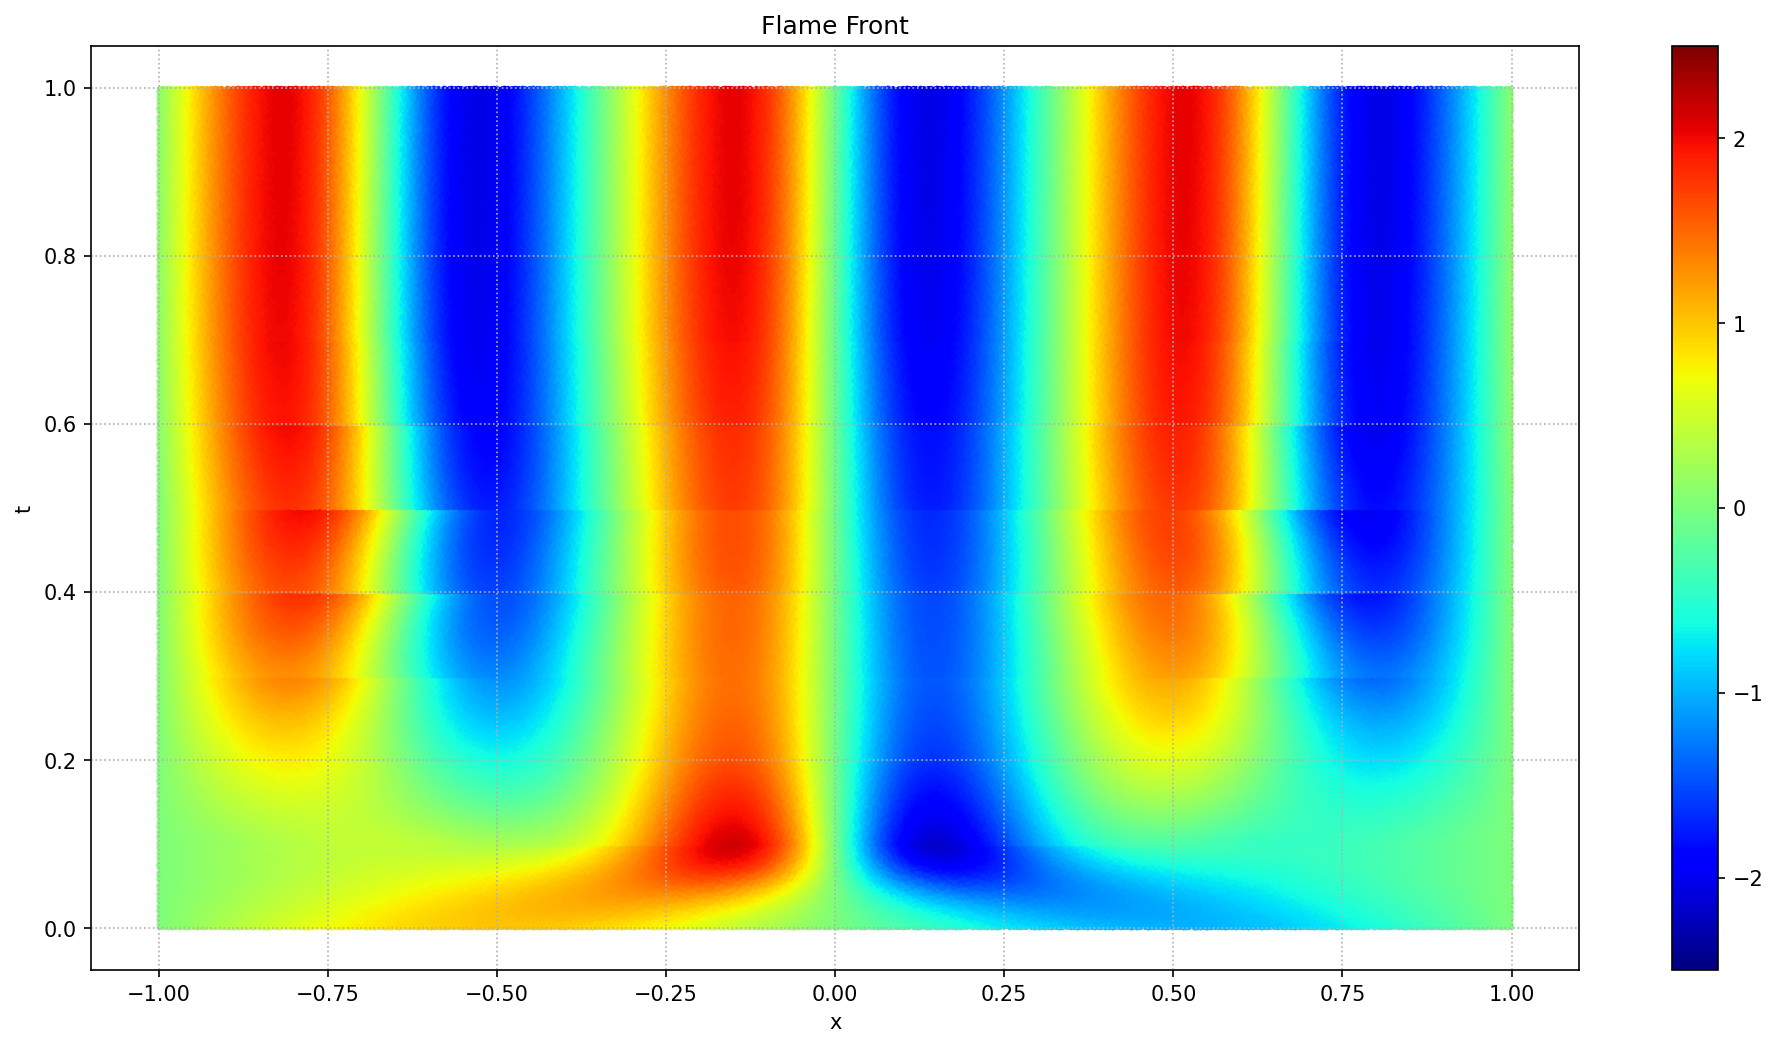

In [7]:
# Plot results with colour
def plotting():
    fig, axs = plt.subplots(1, 1, figsize=(16, 8), dpi=150)
    im1 = axs.scatter(final_inputs[:, 1].cpu().detach(), final_inputs[:, 0].cpu().detach(), c=final_image.cpu().detach(), cmap="jet", s=2, vmin=-2.5, vmax=2.5)
    axs.set_xlabel("x")
    axs.set_ylabel("t")
    plt.colorbar(im1, ax=axs)
    axs.grid(True, which="both", ls=":")
    axs.set_title("Flame Front")
    plt.show()

plotting()

In [8]:
import pandas as pd 

submission = torch.cat((final_inputs, final_image), dim=1)
submission = pd.DataFrame(submission.cpu().detach().numpy())

# Save the DataFrame as a text file
submission.to_csv(r"C:\Users\matth\Downloads\submission_kuramoto.txt", sep=',', index=False, header=['t', 'x', 'u'])